# Implementation of Co-training on Animacy Classifiers

This notebook contains the training of both language models classifier A and classifier B. On top of that, a co-training algorithm is deployed. 

> **Note**: Model B is first created in this notebook and afterwards Model A. This has no meaning. The reason for that is that I used the data set of classifier B for both classifiers and therefore loaded it first.

## Imports of libraries and packages

In [1]:
import os
from pathlib import Path
import pandas as pd
import torch
from datasets import Dataset
from torch.utils.data import Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import csv
import re
import spacy
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import ast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch import nn
from transformers import BertTokenizerFast, BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments, PreTrainedTokenizerFast, EvalPrediction, DataCollatorWithPadding, BertForSequenceClassification
import transformers
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

C:\Users\Anwender\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and format all files needed for the classifiers

> **To-do: Change path_to_folder to direct to folder "Code" !**

In [2]:
path_to_folder = "C:\\Users\\Anwender\\Desktop\\" 

In [3]:
# load all csv files for training and validation for labeled data and unlabeled data including the predictions from A and B
labeled_data = path_to_folder + "Code\\CoTraining\\labeledData.csv"
unlabeled_data = path_to_folder + "Code\\CoTraining\\unlabeledData.csv"
train_data = path_to_folder + "Code\\CoTraining\\trainData.csv"
valid_data = path_to_folder + "Code\\CoTraining\\validData.csv"

labeled_df = pd.read_csv(labeled_data)
unlabeled_df = pd.read_csv(unlabeled_data)
train_df = pd.read_csv(train_data)
valid_df = pd.read_csv(valid_data)

# convert strings from csv back to lists of integers
def convert_string_to_list(df, column_names):
    for column_name in column_names:
        if df[column_name].apply(lambda x: isinstance(x, str)).all():
            df[column_name] = df[column_name].apply(ast.literal_eval)
    return df

data_frames = [
    (labeled_df, ['BIO_tags', 'Animated_NP',
                     'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token']),
    (unlabeled_df, ['BIO_tags', 'Animated_NP',
                     'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token']),
    (train_df, ['BIO_tags', 'Animated_NP',
                     'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token']),
    (valid_df, ['BIO_tags', 'Animated_NP', 'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token'])
]

for df, column_names in data_frames:
    convert_string_to_list(df, column_names)

## Load all pre-trained BERT models and tokenizers
> **Classifier A** is built on a BERT for **token classification model** and **Classifier B** on a BERT for **sequence classification model**

In [4]:
# load all models and tokenizers for BERT models
nlp = spacy.load("de_core_news_lg")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "bert-base-german-cased"

tokenizer_B = BertTokenizer.from_pretrained(model_name)
model_B = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model_A = BertForTokenClassification.from_pretrained(model_name, num_labels=2)
model_A = model_A.to(device)
tokenizer_A = BertTokenizerFast.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

## Training of Classifier B
Training of classifier B using a pre-trained BERT model and a pre-defined trainer. Afterwards, the metrics are calculcated and plotted.

In [5]:
# train classifier B using a BERT for sequence classification model
def train_classifier_B(train_df, valid_df):
    # extract nominal phrases from sentences to create sequences
    def extract_phrases_and_labels(df):
        phrases = []
        labels = []
        for _, row in df.iterrows():
            extracted_phrases = re.findall(r'\[START\](.*?)\[END\]', row['Tagged_Sentence'])
            extracted_labels = row['Animated_NP']
            if len(extracted_phrases) != len(extracted_labels):
                print(f"Skipping an inconsistent row: {row}")
                continue
            phrases.extend(extracted_phrases)
            labels.extend(extracted_labels)
        return phrases, labels

    train_phrases, train_labels = extract_phrases_and_labels(train_df)
    valid_phrases, valid_labels = extract_phrases_and_labels(valid_df)

    class NominalPhraseDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = self.labels[idx]
            return item


        def __len__(self):
            return len(self.labels)
    
    # encodings needed for processing the input data
    train_encodings = tokenizer_B(train_phrases, truncation=True, padding=True, max_length=512)
    valid_encodings = tokenizer_B(valid_phrases, truncation=True, padding=True, max_length=512)

    train_dataset = NominalPhraseDataset(train_encodings, train_labels)
    valid_dataset = NominalPhraseDataset(valid_encodings, valid_labels)

    # metrics for evaluation of model
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        return {
            'accuracy': accuracy_score(p.label_ids, preds),
            'precision': precision_score(p.label_ids, preds, average='macro'),
            'f1': f1_score(p.label_ids, preds, average='macro'), 
            'recall': recall_score(p.label_ids, preds, average='macro'),
        }

    # training arguments set to a batch_size of 16 and epochs to 3 and creation of trainer instance
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
    )

    trainer = Trainer(
        model=model_B,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # perform evaluation of the model on the validation dataset
    eval_results = trainer.evaluate()

    # plot the metrics
    accuracy = eval_results['eval_accuracy']
    precision = eval_results['eval_precision']
    f1 = eval_results['eval_f1']
    recall = eval_results['eval_recall']

    metrics = ['Accuracy', 'Precision', 'F1 Score', 'Recall']
    values = [accuracy, precision, f1, recall]
    bars = plt.bar(metrics, values)

    plt.title('Evaluation Metrics Classifier B')
    plt.ylabel('Score')
    plt.ylim(0, 1.2)

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{value:.2%}', ha='center', va='bottom')

    plt.show()
    
    predictions = trainer.predict(valid_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    
    # compute and plot of confusion matrix
    cm = confusion_matrix(valid_labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Classifier B')
    plt.show()

    return trainer.model

C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


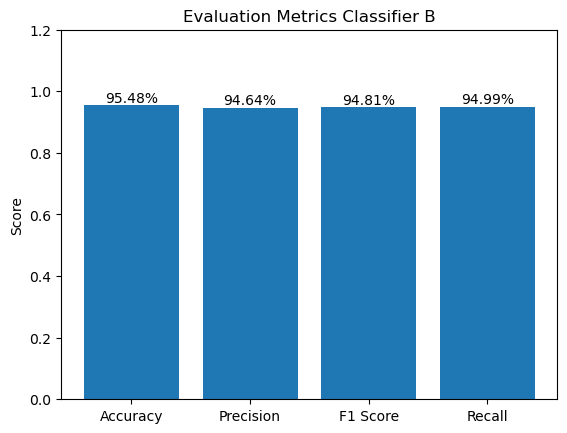

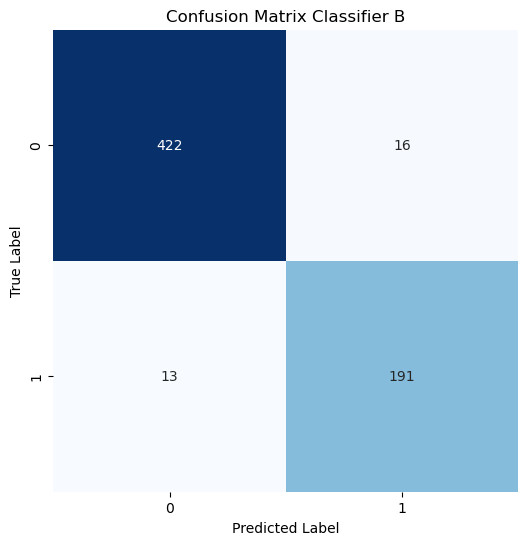

In [6]:
# train the BERT for sequence classification model
trained_model_B = train_classifier_B(train_df, valid_df)

### Predictions for unlabeled data using Classifier B
I used the trained model B to predict unlabeled data from the unlabeled data set. I converted the labels to be accessed by classifier A as well. The unlabeled set is then depicted.

In [7]:
# make predictions for unlabeled dataset using classifier B (BERT for sequence classification model)
def predict_animation_status_and_probs_B(unlabeled_df, model, tokenizer: PreTrainedTokenizerFast):

    def extract_phrases(tagged_sentence):
        return re.findall(r'\[START\](.*?)\[END\]', tagged_sentence)
    
    def tokenize_phrases(phrases):
        if not phrases:
            return None
        return tokenizer(phrases, truncation=True, padding=True, max_length=512, return_tensors="pt")

    def predict_with_model(tokenized_phrases, model):
        device = next(model.parameters()).device
        tokenized_phrases = {k: v.to(device) for k, v in tokenized_phrases.items()}
        with torch.no_grad():
            outputs = model(**tokenized_phrases)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
            return (np.max(probs, axis=-1)).tolist(), np.argmax(probs, axis=-1).tolist()

    # convert the predictions made for one sequence to token-level so that the information later can be accessed by classifier A as well
    def create_animated_tokens(row):
        tagged_sentence = row['Tagged_Sentence']
        animated_np = row['Animated_NP']
        tokens = tagged_sentence.split()
        animated_tokens = []
        inside_animated_phrase = False
        animated_np_index = 0
        for token in tokens:
            if token == '[START]':
                inside_animated_phrase = animated_np[animated_np_index] == 1
                continue
            elif token == '[END]':
                inside_animated_phrase = False
                animated_np_index += 1
                continue
            animated_tokens.append(1 if inside_animated_phrase else 0)
        return animated_tokens

    def create_animated_tokens_and_probs(row):
        bio_tags = row['BIO_tags']
        animated_np_probs = row['Animated_Prob_NP']
        animated_prob_token = []
        np_counter = 0
        for tag in bio_tags:
            if tag == "B":
                if np_counter < len(animated_np_probs):
                    current_prob = animated_np_probs[np_counter]
                    np_counter += 1
                else:
                    current_prob = 0
                animated_prob_token.append(current_prob)
            elif tag == "I":
                animated_prob_token.append(current_prob)
            else:
                animated_prob_token.append(0.99)
        return animated_prob_token
    
    predictions_df = unlabeled_df.copy()
    predictions_df['Animated_Prob_NP'] = None

    for index, row in predictions_df.iterrows():
        phrases = extract_phrases(row['Tagged_Sentence'])
        tokenized_phrases = tokenize_phrases(phrases)

        if tokenized_phrases is not None and '[START]' in row['Tagged_Sentence']:
            confidences, predictions = predict_with_model(tokenized_phrases, model)
            predictions_df.at[index, 'Animated_NP'] = predictions
            predictions_df.at[index, 'Animated_Prob_NP'] = [round(conf, 2) for conf in confidences]
        else:
            predictions_df.at[index, 'Animated_NP'] = []
            predictions_df.at[index, 'Animated_Prob_NP'] = []
    
    # Create columns for token classification and apply mehtods to convert the sequence classification to a token-level
    predictions_df['Animated_Token'] = predictions_df.apply(create_animated_tokens, axis=1)
    predictions_df['Animated_Prob_Token'] = predictions_df.apply(create_animated_tokens_and_probs, axis=1)

    return predictions_df

# make the predictions for unlabeled data
unlabeled_df_B_pred = predict_animation_status_and_probs_B(unlabeled_df, trained_model_B, tokenizer_B)
unlabeled_df_B_pred

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP,Animated_Prob_NP,Animated_Token,Animated_Prob_Token
0,"Meine Damen und Herren , beim Kampf gegen den ...",[START] Meine Damen [END] und [START] Herren [...,"[B, I, O, B, O, O, B, O, B, I, O, O, O, O, O, ...","[1, 1, 0, 1, 1, 0, 1, 0]","[1.0, 1.0, 1.0, 0.98, 0.99, 1.0, 1.0, 1.0]","[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 0..."
1,Erstens .,Erstens .,"[O, O]",[],[],"[0, 0]","[0.99, 0.99]"
2,"Ohne ein genaues Bild davon , wo sich der IS a...","Ohne [START] ein genaues Bild [END] davon , wo...","[O, B, I, I, O, O, O, B, B, I, O, B, O, O, O, ...","[0, 0, 1, 0, 0, 1, 0, 0, 1]","[1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 1.0, 0..."
3,Daher ist es gerade jetzt ganz besonders wicht...,Daher ist [START] es [END] gerade jetzt ganz b...,"[O, O, B, O, O, O, O, O, O, B, I, O, B, I, B, ...","[0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.88]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99..."
4,Zweitens .,Zweitens .,"[O, O]",[],[],"[0, 0]","[0.99, 0.99]"
...,...,...,...,...,...,...,...
2593,Er hat einmal sinngemäß gesagt : Die Humanität...,[START] Er [END] hat einmal sinngemäß gesagt :...,"[B, O, O, O, O, O, B, I, O, B, I, B, I, O, B, ...","[0, 0, 0, 0, 0]","[1.0, 0.99, 1.0, 0.83, 0.99]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99..."
2594,"– Wenn das so war , dann ist sie erst recht di...","– Wenn [START] das [END] so war , dann ist [ST...","[O, O, B, O, O, O, O, O, B, B, I, I, I, B, I, ...","[0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99..."
2595,Vielen Dank .,Vielen Dank .,"[O, O, O]",[],[],"[0, 0, 0]","[0.99, 0.99, 0.99]"
2596,"Vielen Dank , Herr Minister .","Vielen Dank , [START] Herr Minister [END] .","[O, O, O, B, I, O]",[1],[1.0],"[0, 0, 0, 1, 1, 0]","[0.99, 0.99, 0.99, 1.0, 1.0, 0.99]"


## Training of Classifier A
Training of classifier B using a pre-trained BERT model and a pre-defined trainer. Afterwards, the metrics are calculcated and plotted.

In [8]:
# train classifier A on a BERT for token classification model
def train_classifier_A(train_df, valid_df):
    # pre-process input data so that it can be interpreted by the BERT model
    def tokenize_and_align_labels(sentences, ner_tags):
        # tokenize the input sentences with pre-trained tokenizer
        tokenized_inputs = tokenizer_A(sentences, truncation=True, is_split_into_words=False, return_tensors="pt", padding=True)
        labels = []

        for i, label in enumerate(ner_tags):
            word_ids = tokenized_inputs.word_ids(batch_index=i)  # map tokens to their respective word
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:  # set the special tokens (like CLS and SEP) to -100
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx and word_idx < len(label):
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)

        tokenized_inputs["labels"] = labels

        return tokenized_inputs

    # preperation of sentences and labels for training and validation sets
    sentences_train = train_df["Sentence"].tolist()
    tags_train = train_df["Animated_Token"].tolist()
    sentences_valid = valid_df["Sentence"].tolist()
    tags_valid = valid_df["Animated_Token"].tolist()
    
    # check for inconsistencies in the training set
    for index, (sentence, labels) in enumerate(zip(sentences_train, tags_train)):
        if labels is None:
            print(f'Missing labels in training set at index {index}')
        elif len(sentence.split()) != len(labels):
            print(f'Inconsistency in training set at index {index}: {len(sentence.split())} tokens in sentence, {len(labels)} labels')
    
    # check for inconsistencies in the validation set
    for index, (sentence, labels) in enumerate(zip(sentences_valid, tags_valid)):
        if labels is None:
            print(f'Missing labels in validation set at index {index}')
        elif len(sentence.split()) != len(labels):
            print(f'Inconsistency in validation set at index {index}: {len(sentence.split())} tokens in sentence, {len(labels)} labels')
    
    tokenized_and_aligned_train = tokenize_and_align_labels(sentences_train, tags_train)
    tokenized_and_aligned_valid = tokenize_and_align_labels(sentences_valid, tags_valid)
    
    # train the BERT for token classification model
    def train_fn(data_loader, model, optimizer, device):
        model.train()
        train_loss = 0

        for batch in data_loader:
            # extract data from batch with token IDs and the corresponding attention mask and labels
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # calculate loss
            loss = outputs.loss
            loss.backward()

            # update weights of the model and accumulate loss
            optimizer.step()
            train_loss += loss.item()

        return train_loss

    tokenized_and_aligned_train = tokenize_and_align_labels(sentences_train, tags_train)
    tokenized_and_aligned_valid = tokenize_and_align_labels(sentences_valid, tags_valid)

    class CustomDataset(Dataset):
        def __init__(self, tokenized_inputs):
            self.tokenized_inputs = tokenized_inputs

        def __len__(self):
            return len(self.tokenized_inputs["input_ids"])

        def __getitem__(self, idx):
            return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


    # create of datasets and dataloaders
    train_dataset = CustomDataset(tokenized_and_aligned_train)
    valid_dataset = CustomDataset(tokenized_and_aligned_valid)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16)

    # use AdamW optimizer
    optimizer = torch.optim.AdamW(model_A.parameters(), lr=5e-5)

    # ensure that models trains on GPU if available to enhance speed of training. if not available use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_A.to(device)

    # calculate loss and print out
    train_loss = train_fn(train_loader, model_A, optimizer, device)
    print(f"Training Loss: {train_loss}")

    # evaluation of the model
    def eval_fn(data_loader, model, device):
        model.eval()

        eval_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device, dtype=torch.long)

                output = model(input_ids, attention_mask=attention_mask, labels=labels)
                step_loss = output.loss
                eval_prediction = output.logits

                eval_loss += step_loss.item()
                eval_prediction = eval_prediction.cpu().numpy()
                actual = labels.cpu().numpy()

                pred_flat = np.argmax(eval_prediction, axis=-1).ravel().tolist()
                actual_flat = actual.ravel().tolist()

                for p, a in zip(pred_flat, actual_flat):
                    # ignore predictions and labels where label is -100 (since that are the special tokens SEP and CLS)
                    if a != -100:
                        predictions.append(p)
                        true_labels.append(a)

        # computation and plot of the metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='macro')
        recall = recall_score(true_labels, predictions, average='macro')
        f1 = f1_score(true_labels, predictions, average='macro')

        metrics = [accuracy, precision, f1, recall]
        metric_names = ["Accuracy", "Precision", "F1 Score", "Recall"]

        bars = plt.bar(metric_names, metrics)
        plt.ylim(0, 1.2)
        plt.title("Evaluation Metrics for Classifier A")

        for bar, metric in zip(bars, metrics):
            height = bar.get_height()
            plt.annotate(f'{metric:.2%}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')

        plt.show()

        # calculate and plot the confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return eval_loss, predictions, true_labels, accuracy, precision, f1, recall

    # train and save model
    def train_engine(epoch, train_data_loader, valid_data_loader, num_labels):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_A.to(device)

        optimizer = torch.optim.Adam(model_A.parameters(), lr=3e-5)

        best_eval_loss = float("inf")
        for i in range(epoch):
            train_loss = train_fn(train_data_loader, model_A, optimizer, device)
            eval_loss, eval_predictions, true_labels, accuracy, precision, f1, recall = eval_fn(valid_data_loader, model_A, device)
            print(f"Accuracy: {accuracy}, Precision: {precision}, F1 Score: {f1}, Recall: {recall}")

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss           

                torch.save(model_A.state_dict(), 'bert-base-german-token-classification')

        return model_A, eval_predictions, true_labels


    # set number of labels to 2 (animate = 1 and inanimate = 0)
    num_labels = 2

    # set number of training epochs to 2 - 4 (according to BERT paper (Devlin et al.))
    num_epochs = 3

    model, eval_predictions, true_labels = train_engine(num_epochs, train_loader, valid_loader, num_labels)
    return model

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Training Loss: 6.570562317967415


100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


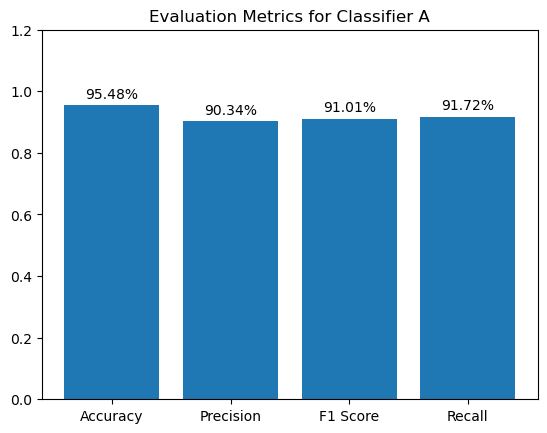

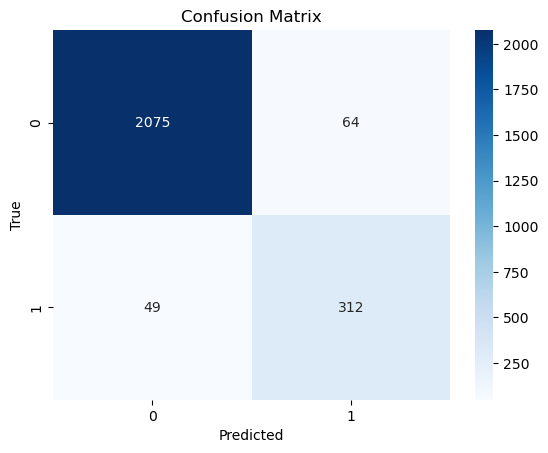

Accuracy: 0.9548, Precision: 0.9033587770966062, F1 Score: 0.9100842788806909, Recall: 0.9171727021843381


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


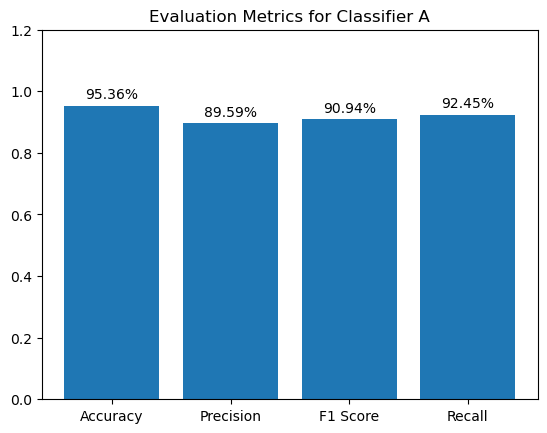

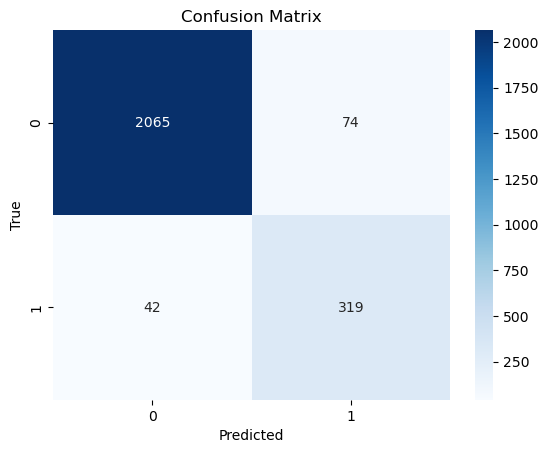

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9536, Precision: 0.895885639894161, F1 Score: 0.9094170078626038, Recall: 0.924530452136098


100%|██████████| 9/9 [00:00<00:00, 130.85it/s]


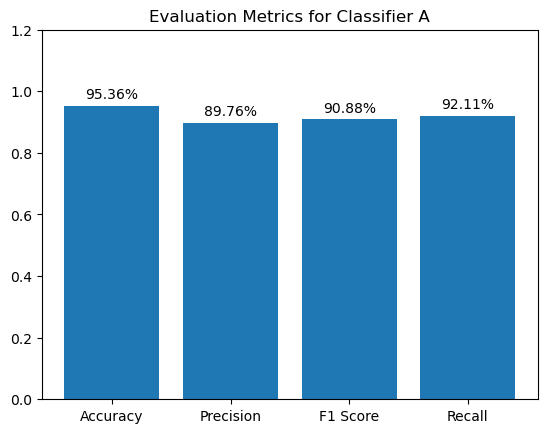

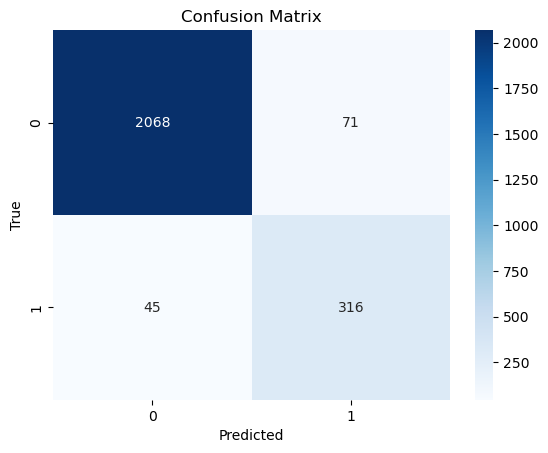

Accuracy: 0.9536, Precision: 0.8976203665997742, F1 Score: 0.9088192533491631, Recall: 0.9210765897544482


In [9]:
# call the BERT for token classification model (classifier A)
trained_model_A = train_classifier_A(train_df, valid_df)

### Predictions for unlabeled data using Classifier A
I used the trained model A to predict unlabeled data from the unlabeled data set. I converted the labels to be accessed by classifier B as well. The unlabeled set is then depicted.

In [10]:
# make predictions for unlabeled data using classifier A (BERT for token classification model)

def predict_animation_status_and_probs_A(unlabeled_df, model, tokenizer, device):
    # predict class labels 0 and 1
    def predict_and_label(unlabeled_df, model, tokenizer, device):
        sentences = unlabeled_df["Sentence"].tolist()
        tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=False, return_tensors="pt", padding=True)
        
        tokenized_inputs_tensors = {k: v.to(device) for k, v in tokenized_inputs.items()}
        
        model.eval()
        with torch.no_grad():
            outputs = model(**tokenized_inputs_tensors)
        
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()
        
        label_map = {0: 0, 1: 1}
        sentence_level_predictions = []
        sentence_level_probabilities = []
        for i, (prediction, probability) in enumerate(zip(predictions, probabilities)):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            labels = []
            probs = []
            for word_idx, (label_id, prob) in zip(word_ids, zip(prediction, probability)):
                if word_idx is None:
                    continue
                elif word_idx != previous_word_idx:
                    labels.append(label_map[label_id])
                    probs.append(round(prob[label_id].item(), 2))
                previous_word_idx = word_idx
            sentence_level_predictions.append(labels)
            sentence_level_probabilities.append(probs)
        
        unlabeled_df["Animated_Token"] = sentence_level_predictions
        unlabeled_df["Animated_Prob_Token"] = sentence_level_probabilities
        
        return unlabeled_df
    
    def adjust_animacy_based_on_bio_tags(df):
        def modify_animacy(row):
            bio_tags = row['BIO_tags']
            animated_tokens = row['Animated_Token'].copy()
            
            if len(bio_tags) != len(animated_tokens):
                return animated_tokens
            
            for i in range(len(bio_tags)):
                if bio_tags[i] == 'O':
                    animated_tokens[i] = 0
            
            return animated_tokens
        
        df['Animated_Token'] = df.apply(lambda row: modify_animacy(row), axis=1)
        
        return df
    
    # transform predictions for every token to a sequence (nominal phrase) to be accessable for classifier B
    def predict_animated_np(row):
        bio_tags = row['BIO_tags']
        animated_tokens = row['Animated_Token']

        animated_np = []

        current_animacy_value = 0
        inside_nominal_phrase = False

        for bio_tag, animated_token in zip(bio_tags, animated_tokens):
            if bio_tag == 'B':
                if inside_nominal_phrase:
                    animated_np.append(current_animacy_value)
                inside_nominal_phrase = True
                current_animacy_value = animated_token
            elif bio_tag == 'I' and inside_nominal_phrase:
                current_animacy_value = max(current_animacy_value, animated_token)
            elif bio_tag == 'O' and inside_nominal_phrase:
                animated_np.append(current_animacy_value)
                inside_nominal_phrase = False

        if inside_nominal_phrase:
            animated_np.append(current_animacy_value)

        return animated_np

    # calculate probabilities for nominal phrases for classifier B
    def calculate_animated_np_prob(row):
        bio_tags = row['BIO_tags']
        animated_token_probs = row['Animated_Prob_Token']

        animated_np_prob = []
        current_prob_sum = 0
        current_token_count = 0
        inside_nominal_phrase = False

        for bio_tag, animated_token_prob in zip(bio_tags, animated_token_probs):
            if bio_tag == 'B':
                if inside_nominal_phrase:
                    average_prob = round(current_prob_sum / current_token_count, 2)
                    animated_np_prob.append(average_prob)
                inside_nominal_phrase = True
                current_prob_sum = animated_token_prob
                current_token_count = 1
            elif bio_tag == 'I' and inside_nominal_phrase:
                current_prob_sum += animated_token_prob
                current_token_count += 1
            elif bio_tag == 'O' and inside_nominal_phrase:
                average_prob = round(current_prob_sum / current_token_count, 2)
                animated_np_prob.append(average_prob)
                inside_nominal_phrase = False

        if inside_nominal_phrase:
            average_prob = round(current_prob_sum / current_token_count, 2)
            animated_np_prob.append(average_prob)

        return animated_np_prob

    
    # prevent modifying the original unlabeled dataframe
    unlabeled_df_copy = unlabeled_df.copy()

    pred_labeled_df = predict_and_label(unlabeled_df_copy, model, tokenizer, device)
    pred_labeled_df = adjust_animacy_based_on_bio_tags(pred_labeled_df)
    pred_labeled_df['Animated_NP'] = pred_labeled_df.apply(predict_animated_np, axis=1)
    pred_labeled_df['Animated_Prob_NP'] = pred_labeled_df.apply(calculate_animated_np_prob, axis=1)

    return pred_labeled_df

unlabeled_df_A_pred = predict_animation_status_and_probs_A(unlabeled_df, trained_model_A, tokenizer_A, device)
unlabeled_df_A_pred

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP,Animated_Prob_NP,Animated_Token,Animated_Prob_Token
0,"Meine Damen und Herren , beim Kampf gegen den ...",[START] Meine Damen [END] und [START] Herren [...,"[B, I, O, B, O, O, B, O, B, I, O, O, O, O, O, ...","[1, 1, 0, 1, 0, 0, 1, 0]","[1.0, 1.0, 1.0, 0.62, 1.0, 1.0, 0.98, 1.0]","[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.58..."
1,Erstens .,Erstens .,"[O, O]",[],[],"[0, 0]","[1.0, 1.0]"
2,"Ohne ein genaues Bild davon , wo sich der IS a...","Ohne [START] ein genaues Bild [END] davon , wo...","[O, B, I, I, O, O, O, B, B, I, O, B, O, O, O, ...","[0, 0, 1, 0, 0, 1, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 0.88]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Daher ist es gerade jetzt ganz besonders wicht...,Daher ist [START] es [END] gerade jetzt ganz b...,"[O, O, B, O, O, O, O, O, O, B, I, O, B, I, B, ...","[0, 0, 0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.99]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,Zweitens .,Zweitens .,"[O, O]",[],[],"[0, 0]","[1.0, 1.0]"
...,...,...,...,...,...,...,...
2593,Er hat einmal sinngemäß gesagt : Die Humanität...,[START] Er [END] hat einmal sinngemäß gesagt :...,"[B, O, O, O, O, O, B, I, O, B, I, B, I, O, B, ...","[0, 0, 0, 0, 0]","[0.97, 1.0, 1.0, 0.76, 0.97]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2594,"– Wenn das so war , dann ist sie erst recht di...","– Wenn [START] das [END] so war , dann ist [ST...","[O, O, B, O, O, O, O, O, B, B, I, I, I, B, I, ...","[0, 0, 0, 0]","[1.0, 1.0, 1.0, 0.99]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2595,Vielen Dank .,Vielen Dank .,"[O, O, O]",[],[],"[0, 0, 0]","[1.0, 1.0, 1.0]"
2596,"Vielen Dank , Herr Minister .","Vielen Dank , [START] Herr Minister [END] .","[O, O, O, B, I, O]",[1],[1.0],"[0, 0, 0, 1, 1, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"


## Preperations for Co-training
To deploy a co-training algorithm, it was crucial to implement some functions like calculating the weighted average

In [11]:
unlabeled_df_A_pred["Animated_Token"] = unlabeled_df_A_pred["Animated_Token"].apply(lambda x: list(map(int, x)))

''' Calculate the weighted average probability of each sentence and sequence in order to compare them and
    select the one with the highest probability for each class (0 and 1) for classifier A for co-training algorithm'''

def calculate_weighted_average(Animated_Token, Animated_Prob_Token, animated_class):
    # Get indices where Animated_Token is equal to the specified animated_class (0 or 1)
    indices = [index for index, token in enumerate(Animated_Token) if token == animated_class]
    
    # Sum probabilities at the specified indices
    sum_probs_class = sum(Animated_Prob_Token[index] for index in indices)
    
    # Calculate the number of tokens in the specified class
    count_class = len(indices)
    
    # Return the weighted average rounded to 2 decimal places
    return round(sum_probs_class / count_class, 2) if count_class != 0 else 0

def update_dataframe_A(df):
    df["Animated_False_Token"] = df.apply(
        lambda row: calculate_weighted_average(row["Animated_Token"], row["Animated_Prob_Token"], 0),
        axis=1
    )
    df["Animated_True_Token"] = df.apply(
        lambda row: calculate_weighted_average(row["Animated_Token"], row["Animated_Prob_Token"], 1),
        axis=1
    )
    return df

unlabeled_df_A_pred = update_dataframe_A(unlabeled_df_A_pred)

In [12]:
# Assure that the columns contain lists and not strings

unlabeled_df_A_pred["Animated_Token"] = unlabeled_df_A_pred["Animated_Token"].apply(lambda x: list(map(int, x)))
unlabeled_df_B_pred["Animated_Token"] = unlabeled_df_B_pred["Animated_Token"].apply(lambda x: list(map(int, x)))
unlabeled_df_A_pred["Animated_NP"] = unlabeled_df_A_pred["Animated_NP"].apply(lambda x: list(map(int, x)))
unlabeled_df_B_pred["Animated_NP"] = unlabeled_df_B_pred["Animated_NP"].apply(lambda x: list(map(int, x)))

unlabeled_df_A_pred

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP,Animated_Prob_NP,Animated_Token,Animated_Prob_Token,Animated_False_Token,Animated_True_Token
0,"Meine Damen und Herren , beim Kampf gegen den ...",[START] Meine Damen [END] und [START] Herren [...,"[B, I, O, B, O, O, B, O, B, I, O, O, O, O, O, ...","[1, 1, 0, 1, 0, 0, 1, 0]","[1.0, 1.0, 1.0, 0.62, 1.0, 1.0, 0.98, 1.0]","[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.58...",1.00,0.87
1,Erstens .,Erstens .,"[O, O]",[],[],"[0, 0]","[1.0, 1.0]",1.00,0.00
2,"Ohne ein genaues Bild davon , wo sich der IS a...","Ohne [START] ein genaues Bild [END] davon , wo...","[O, B, I, I, O, O, O, B, B, I, O, B, O, O, O, ...","[0, 0, 1, 0, 0, 1, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 0.88]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.00,0.95
3,Daher ist es gerade jetzt ganz besonders wicht...,Daher ist [START] es [END] gerade jetzt ganz b...,"[O, O, B, O, O, O, O, O, O, B, I, O, B, I, B, ...","[0, 0, 0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.99]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.00,0.00
4,Zweitens .,Zweitens .,"[O, O]",[],[],"[0, 0]","[1.0, 1.0]",1.00,0.00
...,...,...,...,...,...,...,...,...,...
2593,Er hat einmal sinngemäß gesagt : Die Humanität...,[START] Er [END] hat einmal sinngemäß gesagt :...,"[B, O, O, O, O, O, B, I, O, B, I, B, I, O, B, ...","[0, 0, 0, 0, 0]","[0.97, 1.0, 1.0, 0.76, 0.97]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.97,0.00
2594,"– Wenn das so war , dann ist sie erst recht di...","– Wenn [START] das [END] so war , dann ist [ST...","[O, O, B, O, O, O, O, O, B, B, I, I, I, B, I, ...","[0, 0, 0, 0]","[1.0, 1.0, 1.0, 0.99]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.00,0.00
2595,Vielen Dank .,Vielen Dank .,"[O, O, O]",[],[],"[0, 0, 0]","[1.0, 1.0, 1.0]",1.00,0.00
2596,"Vielen Dank , Herr Minister .","Vielen Dank , [START] Herr Minister [END] .","[O, O, O, B, I, O]",[1],[1.0],"[0, 0, 0, 1, 1, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.00,1.00


In [13]:
''' Calculate the weighted average probability of each sentence and sequence in order to compare them and
    select the one with the highest probability for each class (0 and 1) for classifier B for co-training algorithm'''

def calculate_weighted_average_B(Animated_NP, Animated_Prob_NP, animated_class):
    # Get indices where Animated_Token is equal to the specified animated_class (0 or 1)
    indices = [index for index, token in enumerate(Animated_NP) if token == animated_class]
    
    # Sum probabilities at the specified indices
    sum_probs_class = sum(Animated_Prob_NP[index] for index in indices)
    
    # Calculate the number of tokens in the specified class
    count_class = len(indices)
    
    # Return the weighted average rounded to 2 decimal places
    return round(sum_probs_class / count_class, 2) if count_class != 0 else 0

def update_dataframe_B(df):
    df["Animated_False_NP"] = df.apply(
        lambda row: calculate_weighted_average(row["Animated_NP"], row["Animated_Prob_NP"], 0),
        axis=1
    )
    df["Animated_True_NP"] = df.apply(
        lambda row: calculate_weighted_average(row["Animated_NP"], row["Animated_Prob_NP"], 1),
        axis=1
    )
    return df

unlabeled_df_B_pred = update_dataframe_B(unlabeled_df_B_pred)
unlabeled_df_B_pred

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP,Animated_Prob_NP,Animated_Token,Animated_Prob_Token,Animated_False_NP,Animated_True_NP
0,"Meine Damen und Herren , beim Kampf gegen den ...",[START] Meine Damen [END] und [START] Herren [...,"[B, I, O, B, O, O, B, O, B, I, O, O, O, O, O, ...","[1, 1, 0, 1, 1, 0, 1, 0]","[1.0, 1.0, 1.0, 0.98, 0.99, 1.0, 1.0, 1.0]","[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 0...",1.00,0.99
1,Erstens .,Erstens .,"[O, O]",[],[],"[0, 0]","[0.99, 0.99]",0.00,0.00
2,"Ohne ein genaues Bild davon , wo sich der IS a...","Ohne [START] ein genaues Bild [END] davon , wo...","[O, B, I, I, O, O, O, B, B, I, O, B, O, O, O, ...","[0, 0, 1, 0, 0, 1, 0, 0, 1]","[1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 1.0, 0...",1.00,0.98
3,Daher ist es gerade jetzt ganz besonders wicht...,Daher ist [START] es [END] gerade jetzt ganz b...,"[O, O, B, O, O, O, O, O, O, B, I, O, B, I, B, ...","[0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.88]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99...",1.00,0.88
4,Zweitens .,Zweitens .,"[O, O]",[],[],"[0, 0]","[0.99, 0.99]",0.00,0.00
...,...,...,...,...,...,...,...,...,...
2593,Er hat einmal sinngemäß gesagt : Die Humanität...,[START] Er [END] hat einmal sinngemäß gesagt :...,"[B, O, O, O, O, O, B, I, O, B, I, B, I, O, B, ...","[0, 0, 0, 0, 0]","[1.0, 0.99, 1.0, 0.83, 0.99]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99...",0.96,0.00
2594,"– Wenn das so war , dann ist sie erst recht di...","– Wenn [START] das [END] so war , dann ist [ST...","[O, O, B, O, O, O, O, O, B, B, I, I, I, B, I, ...","[0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99...",1.00,0.00
2595,Vielen Dank .,Vielen Dank .,"[O, O, O]",[],[],"[0, 0, 0]","[0.99, 0.99, 0.99]",0.00,0.00
2596,"Vielen Dank , Herr Minister .","Vielen Dank , [START] Herr Minister [END] .","[O, O, O, B, I, O]",[1],[1.0],"[0, 0, 0, 1, 1, 0]","[0.99, 0.99, 0.99, 1.0, 1.0, 0.99]",0.00,1.00


In [14]:
# Find entries for each classifier and for each class with highest probability

def find_highest_prob_rows(df, columns):
    max_probs = {col: -1 for col in columns}
    max_rows = {col: None for col in columns}
    selected_indices = set()
    
    for col in columns:
        for index, row in df.iterrows():
            if index in selected_indices:
                continue
            prob = row[col]
            if prob is not None and prob > max_probs[col]:
                max_probs[col] = prob
                max_rows[col] = row
 
        if max_rows[col] is not None:
            selected_indices.add(max_rows[col].name)
    
    return max_rows

column_names_token = ['Animated_True_Token', 'Animated_False_Token']
column_names_NP = ['Animated_True_NP', 'Animated_False_NP']

# Find and store the rows with the highest probabilities
highest_rows_token = find_highest_prob_rows(unlabeled_df_A_pred, column_names_token)
highest_rows_NP = find_highest_prob_rows(unlabeled_df_B_pred, column_names_NP)

# Print the rows with the highest probabilities
for col_name in column_names_token:
    print(f"Row with highest probability for {col_name}:\n", highest_rows_token[col_name], "\n")

for col_name in column_names_NP:
    print(f"Row with highest probability for {col_name}:\n", highest_rows_NP[col_name], "\n")

Row with highest probability for Animated_True_Token:
 Sentence                Wir müssen alles dafür tun , dass der IS nicht...
Tagged_Sentence         [START] Wir [END] müssen [START] alles [END] d...
BIO_tags                 [B, O, B, O, O, O, O, B, I, O, O, O, B, B, O, O]
Animated_NP                                               [1, 0, 1, 0, 0]
Animated_Prob_NP                               [1.0, 1.0, 1.0, 0.99, 1.0]
Animated_Token           [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Animated_Prob_Token     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
Animated_False_Token                                                  1.0
Animated_True_Token                                                   1.0
Name: 5, dtype: object 

Row with highest probability for Animated_False_Token:
 Sentence                Meine Damen und Herren , beim Kampf gegen den ...
Tagged_Sentence         [START] Meine Damen [END] und [START] Herren [...
BIO_tags                [B, I, O, B, O, O, B, O, B

## Co-training algorithm

This code represents the co-training algorithm applied for i iterations. I decided to deploy 15 iterations. In each iteration 10 sentences per class are added, summing up to 40 sentences per iterations. These sentences are then added to the training data set and the classifiers are new trained on the larger data set. The validation set stays the same. After each round of training, the metrics of both classifiers are depicted.

Starting iteration 1


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.8377431294647977


100%|██████████| 9/9 [00:00<00:00, 122.82it/s]


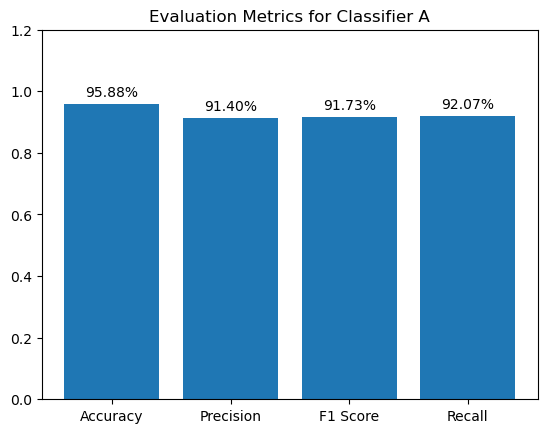

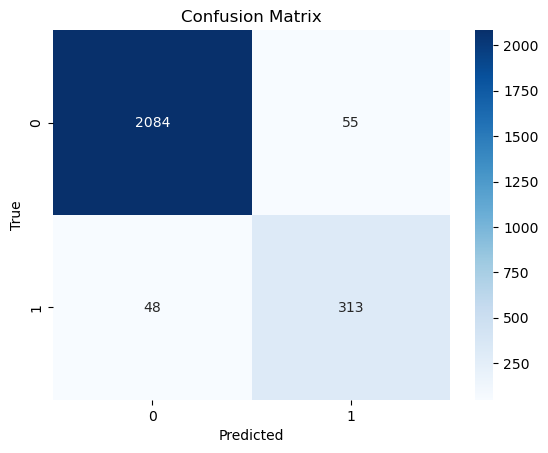

Accuracy: 0.9588, Precision: 0.9140147034831552, F1 Score: 0.9172972151804415, Recall: 0.920661530551854


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 120.38it/s]


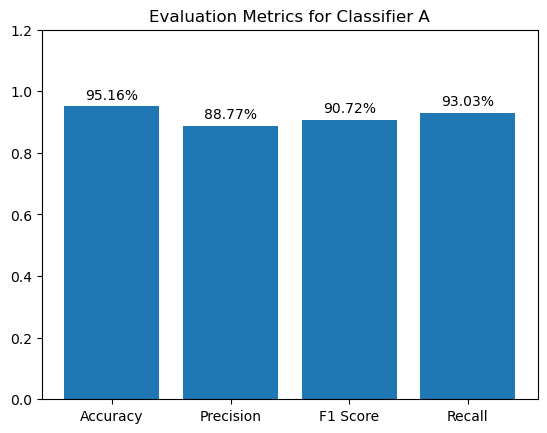

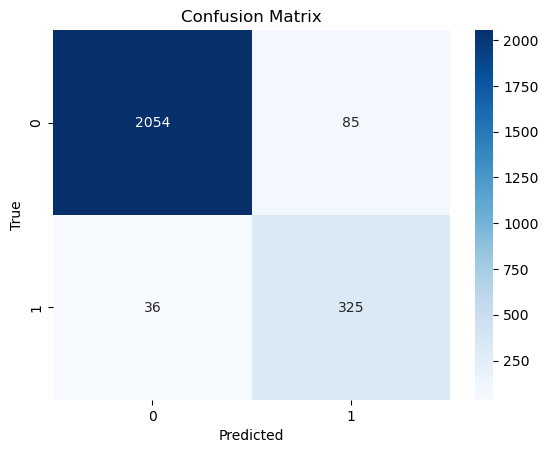

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9516, Precision: 0.8877290232232466, F1 Score: 0.9072244973944652, Recall: 0.9302694064459147


100%|██████████| 9/9 [00:00<00:00, 123.41it/s]


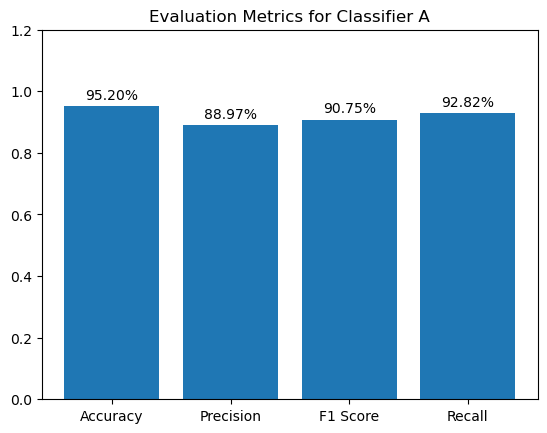

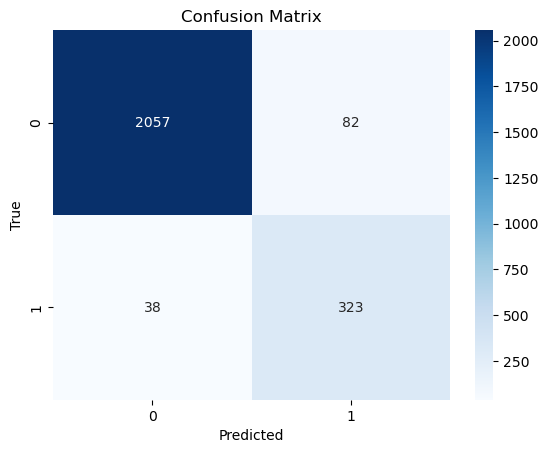

Accuracy: 0.952, Precision: 0.8896962196882643, F1 Score: 0.9075000215833283, Recall: 0.9282005856155114


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.050700


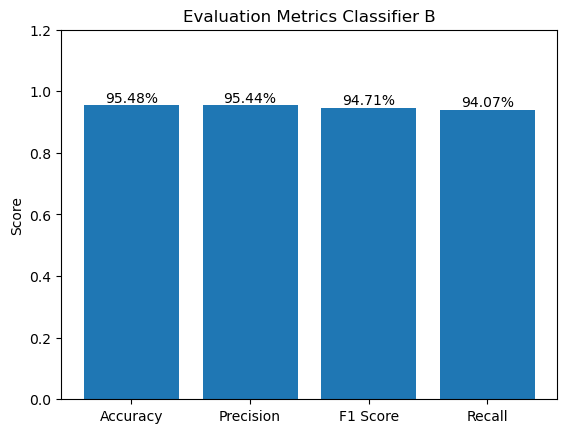

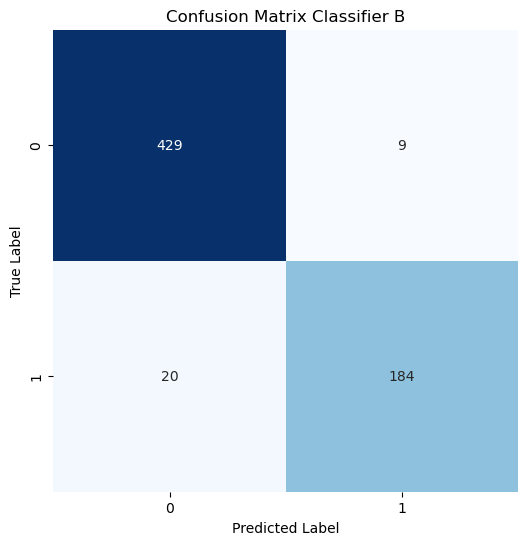

Completed iteration 1
Starting iteration 2
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.6267007707392622


100%|██████████| 9/9 [00:00<00:00, 126.26it/s]


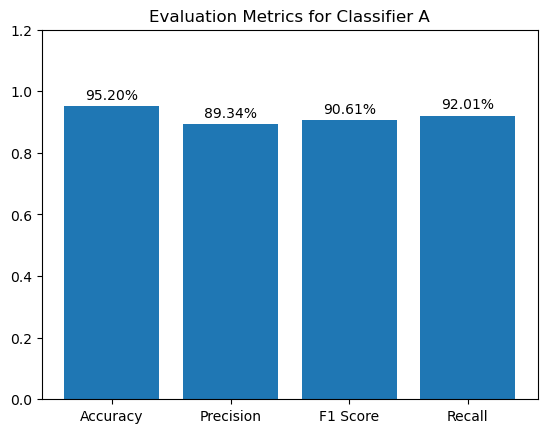

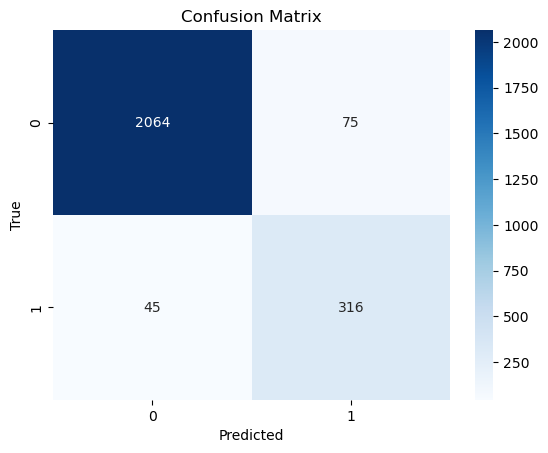

Accuracy: 0.952, Precision: 0.893423508311111, F1 Score: 0.9060884721721361, Recall: 0.9201415733916618


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 125.39it/s]


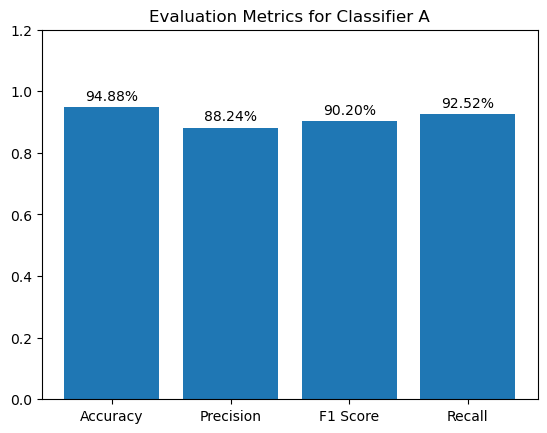

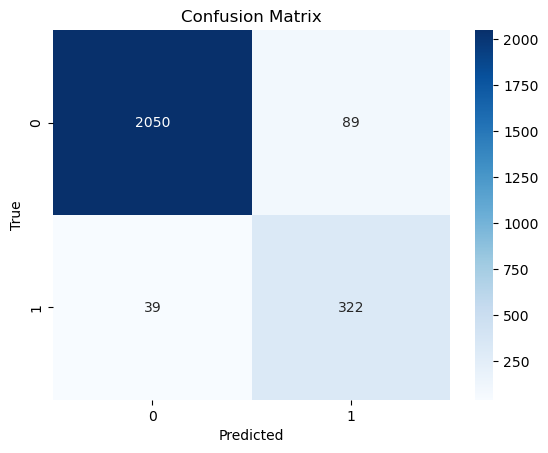

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9488, Precision: 0.8823928840560973, F1 Score: 0.9019612648957603, Recall: 0.9251792654293888


100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


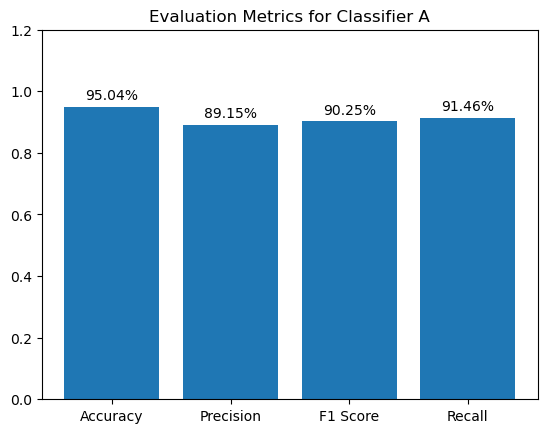

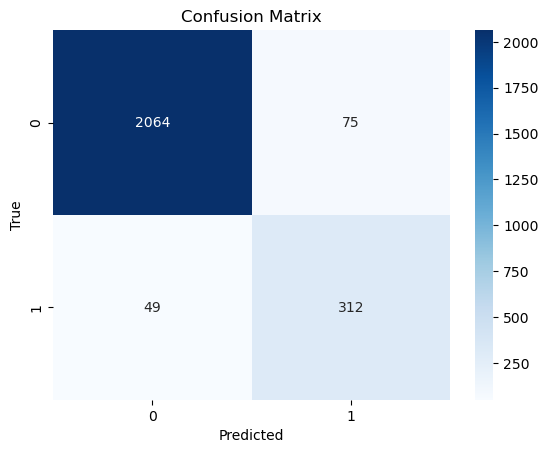

Accuracy: 0.9504, Precision: 0.8915058864100787, F1 Score: 0.9025309259939329, Recall: 0.9146014071866756


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.034900


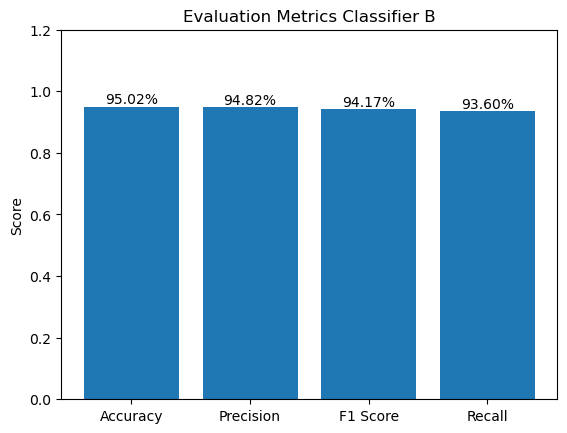

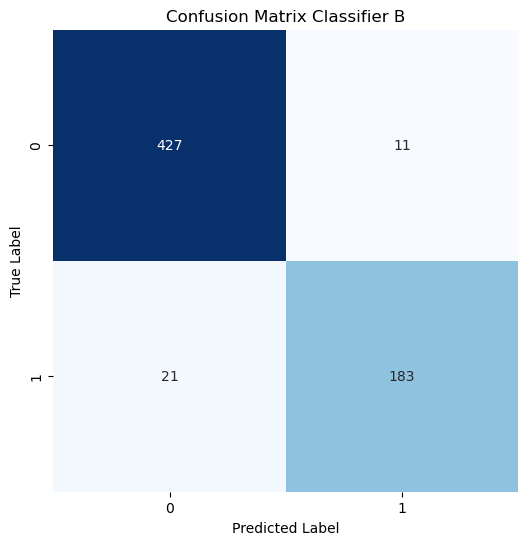

Completed iteration 2
Starting iteration 3
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.910730085481191


100%|██████████| 9/9 [00:00<00:00, 128.97it/s]


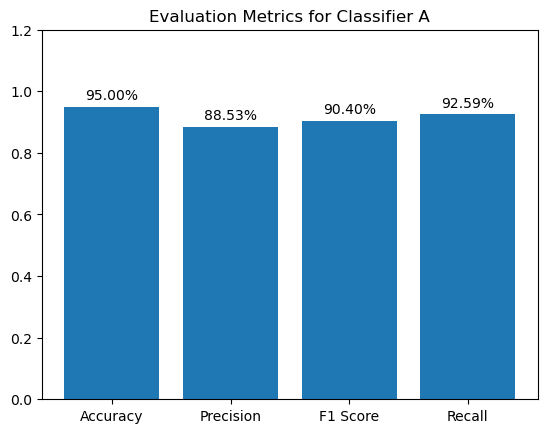

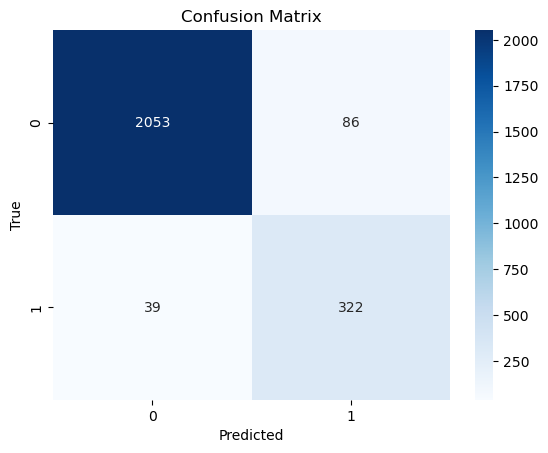

Accuracy: 0.95, Precision: 0.8852866194278859, F1 Score: 0.9039536961537528, Recall: 0.9258805277014786


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 124.51it/s]


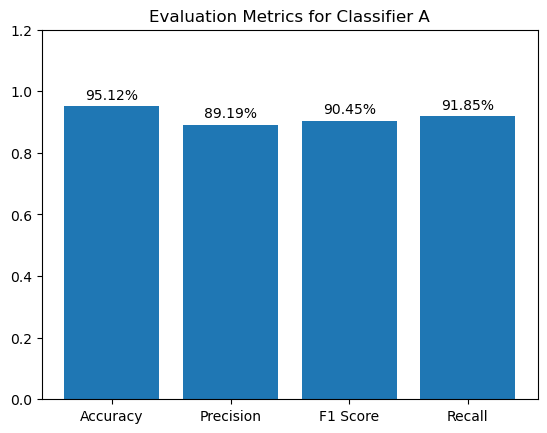

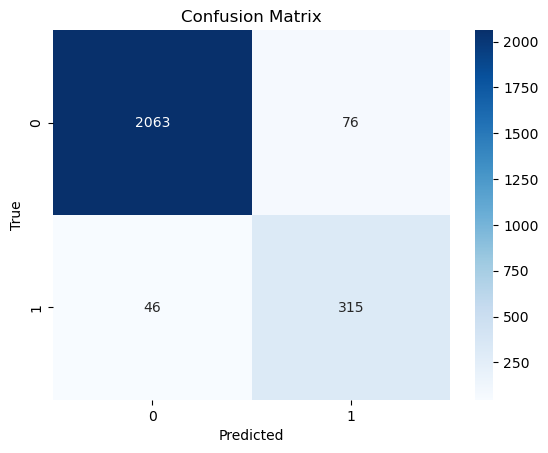

Accuracy: 0.9512, Precision: 0.8919076567481468, F1 Score: 0.9045232800416716, Recall: 0.9185227777497187


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


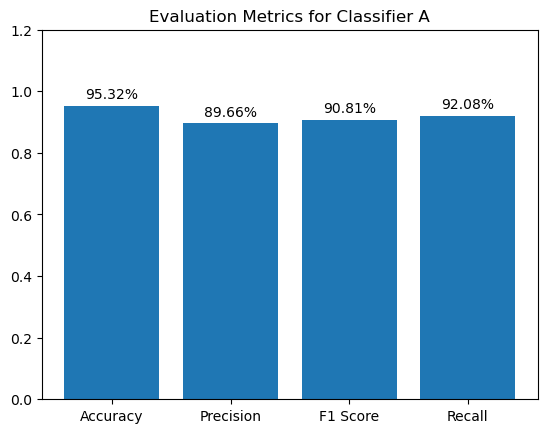

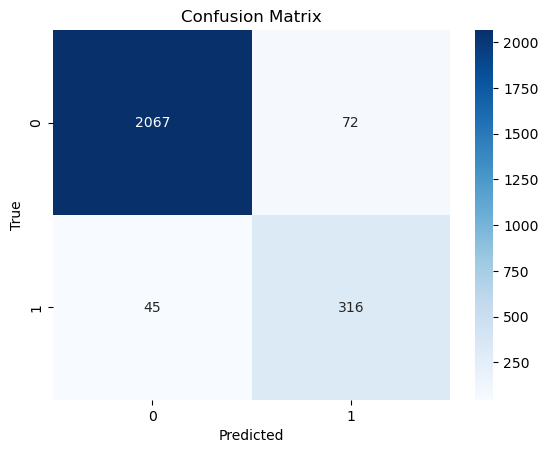

Accuracy: 0.9532, Precision: 0.8965630857544518, F1 Score: 0.9081343932582893, Recall: 0.9208428356637515


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.038700


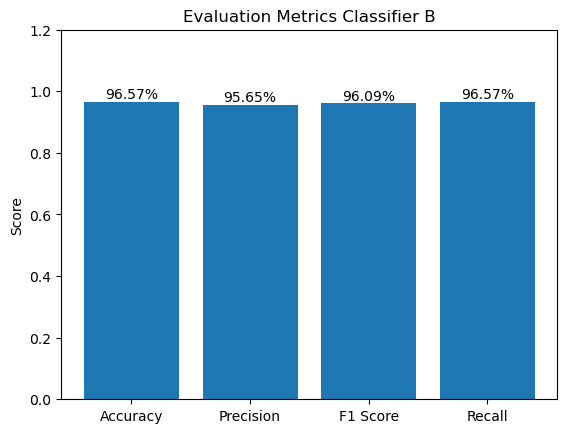

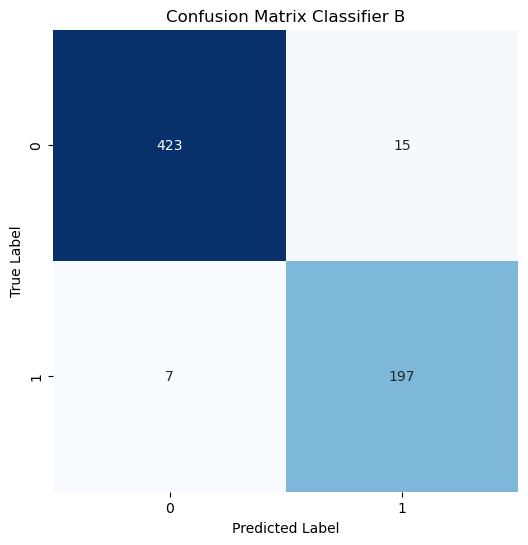

Completed iteration 3
Starting iteration 4
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.7362365149165271


100%|██████████| 9/9 [00:00<00:00, 123.68it/s]


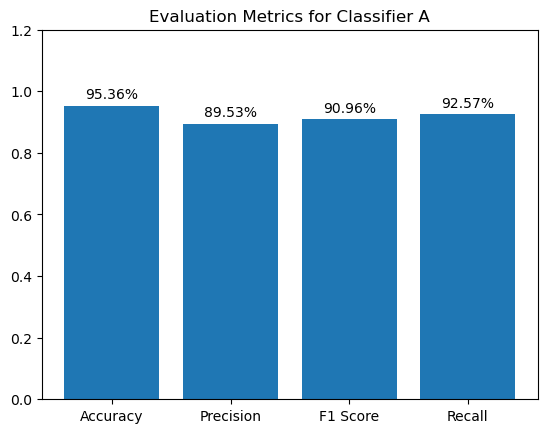

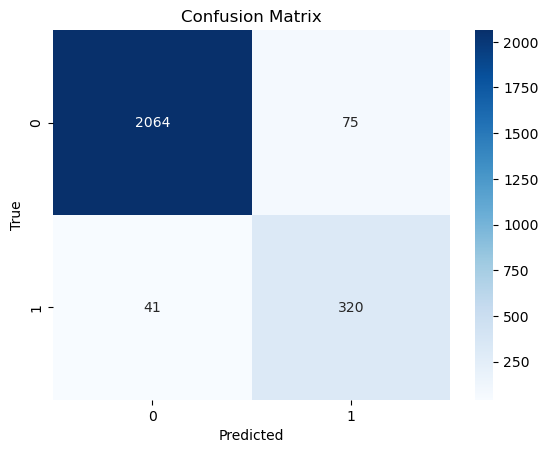

Accuracy: 0.9536, Precision: 0.895324573799573, F1 Score: 0.9096140707827796, Recall: 0.9256817395966479


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 122.82it/s]


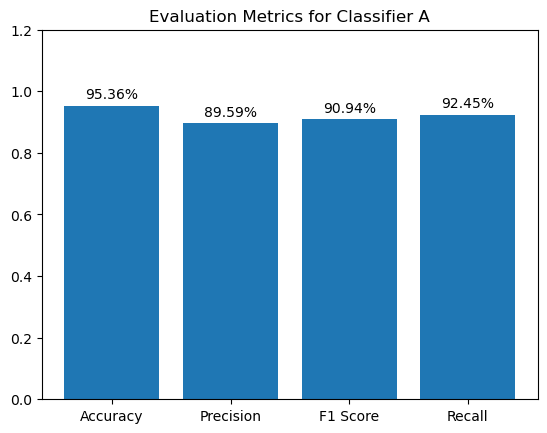

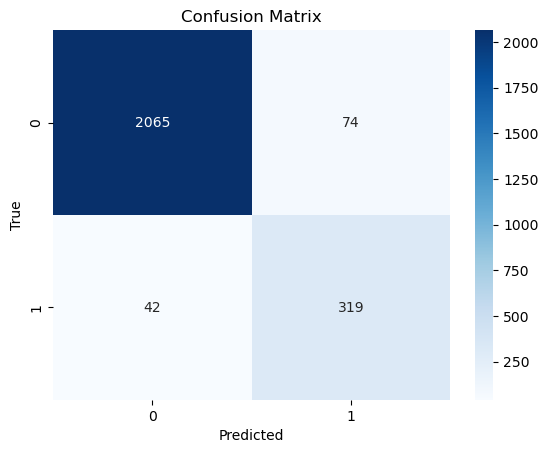

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9536, Precision: 0.895885639894161, F1 Score: 0.9094170078626038, Recall: 0.924530452136098


100%|██████████| 9/9 [00:00<00:00, 122.82it/s]


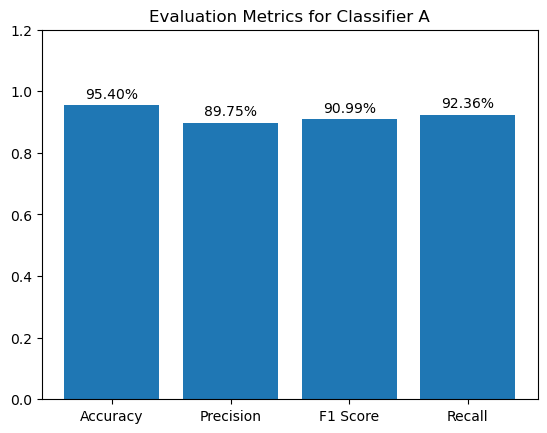

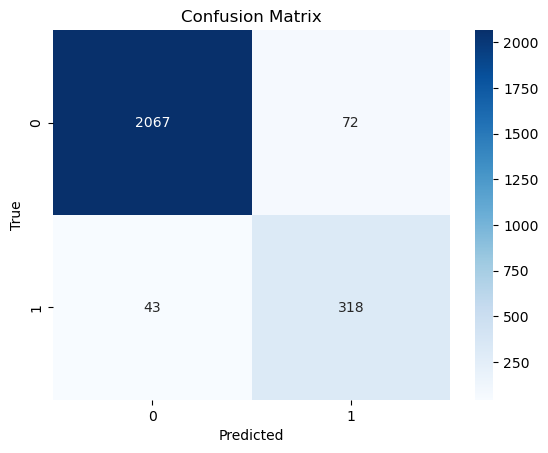

Accuracy: 0.954, Precision: 0.8975027342325921, F1 Score: 0.9099028235358269, Recall: 0.9236129187662446


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.033200


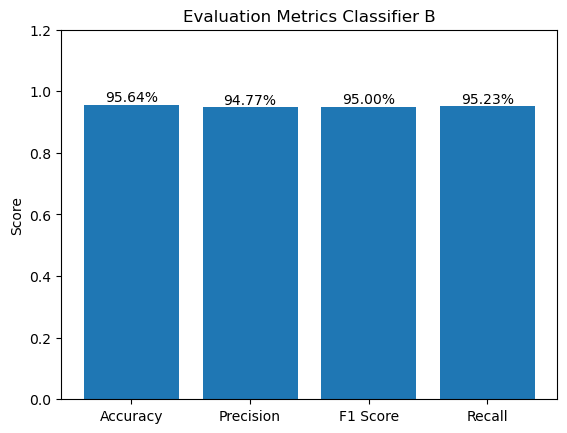

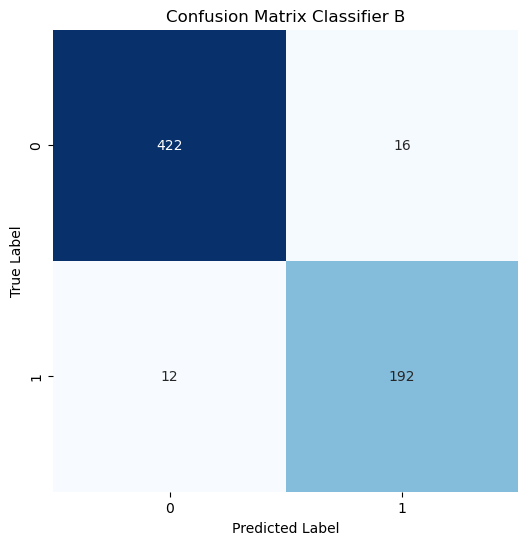

Completed iteration 4
Starting iteration 5
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 1.14428958744611


100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


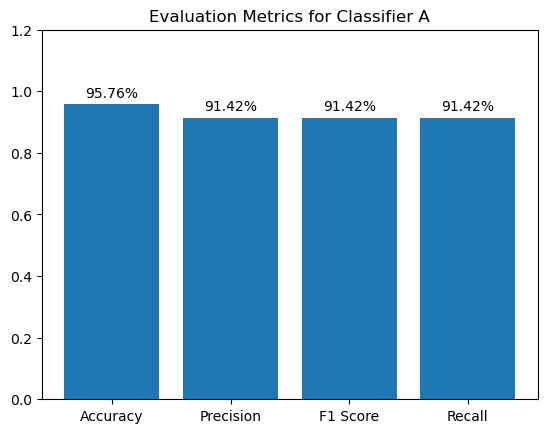

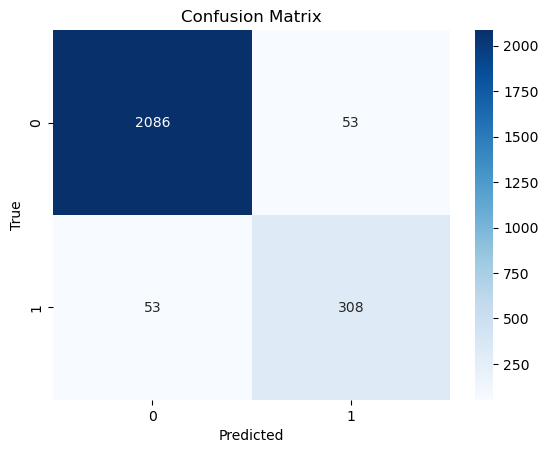

Accuracy: 0.9576, Precision: 0.9142038309770144, F1 Score: 0.9142038309770144, Recall: 0.9142038309770144


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 126.26it/s]


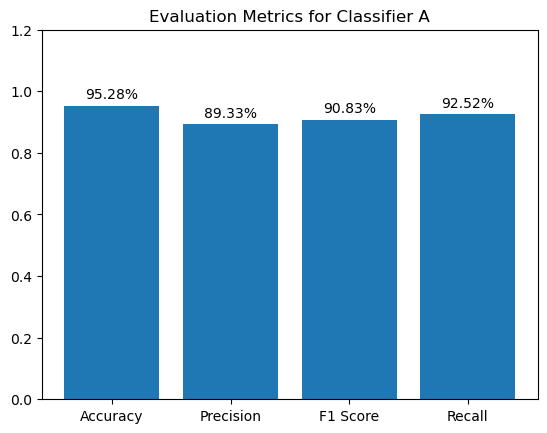

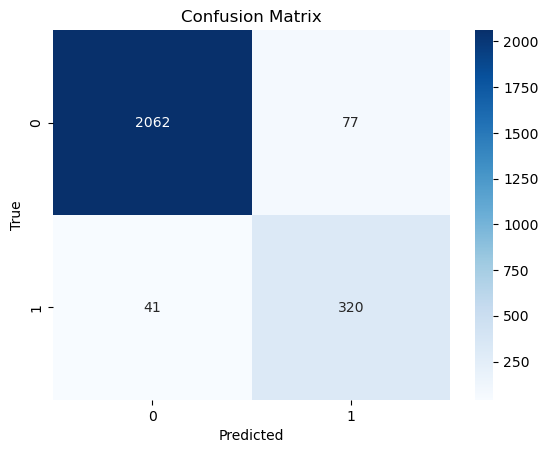

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9528, Precision: 0.8932746909476806, F1 Score: 0.9082550546799875, Recall: 0.9252142314152547


100%|██████████| 9/9 [00:00<00:00, 130.85it/s]


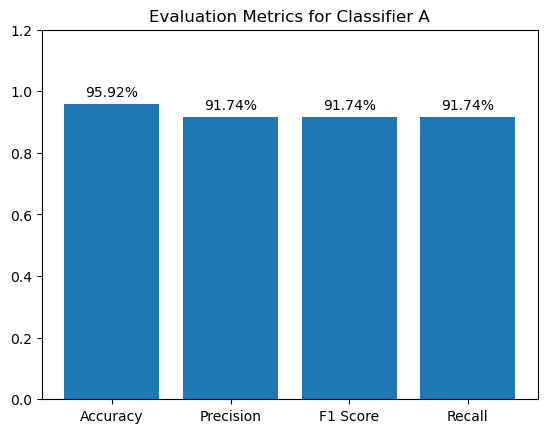

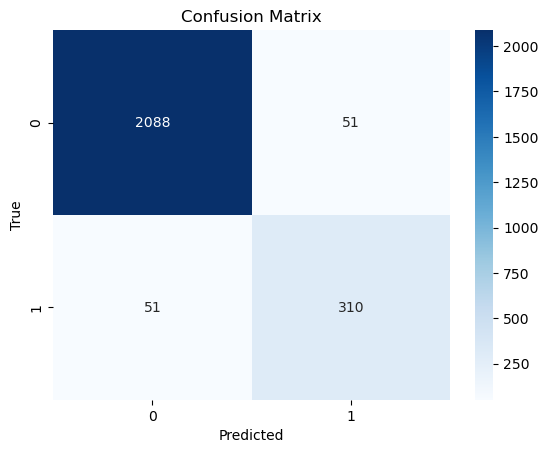

Accuracy: 0.9592, Precision: 0.9174414222609006, F1 Score: 0.9174414222609006, Recall: 0.9174414222609006


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.025000


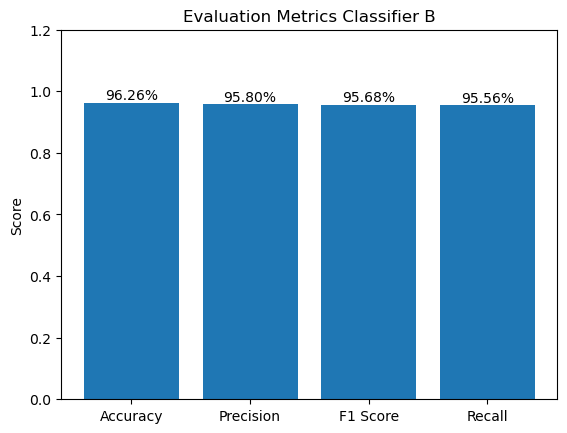

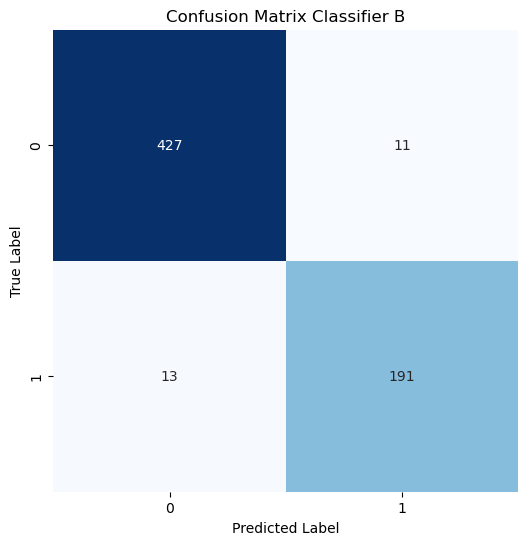

Completed iteration 5
Starting iteration 6
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.5924959173935349


100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


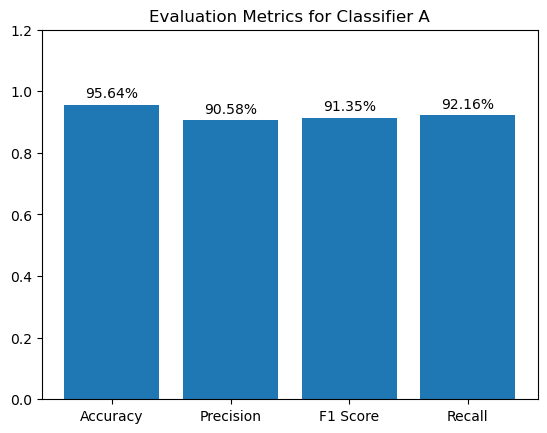

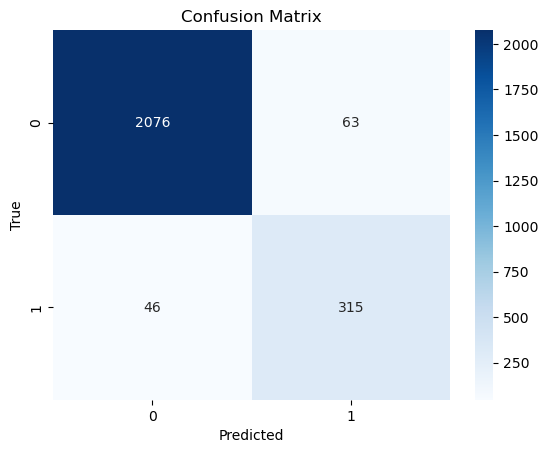

Accuracy: 0.9564, Precision: 0.905827835375432, F1 Score: 0.9134612666920514, Recall: 0.9215615809287743


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 132.77it/s]


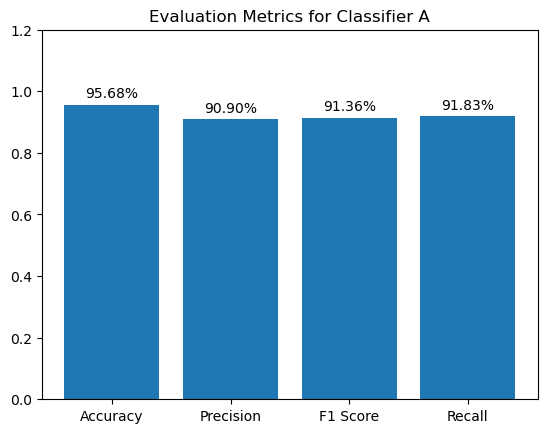

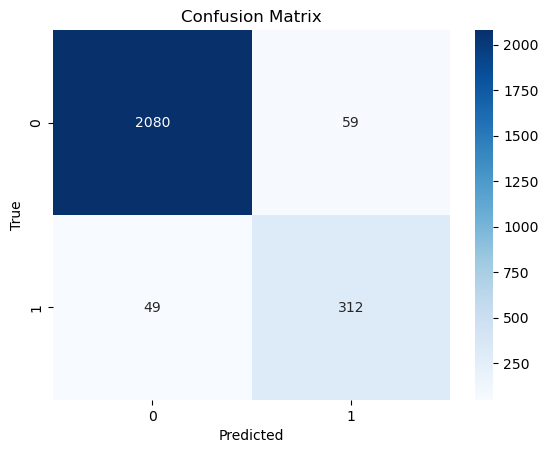

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9568, Precision: 0.9089774250847303, F1 Score: 0.9135772120392706, Recall: 0.918341472637821


100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


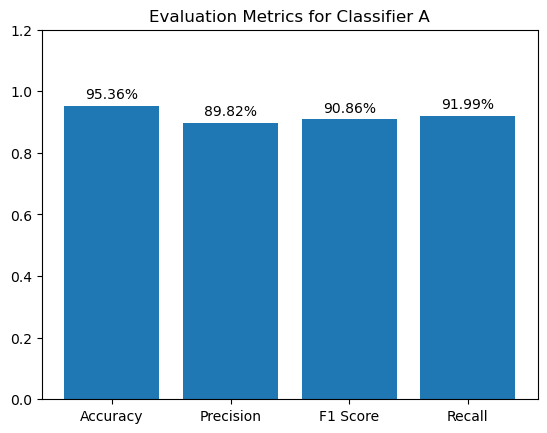

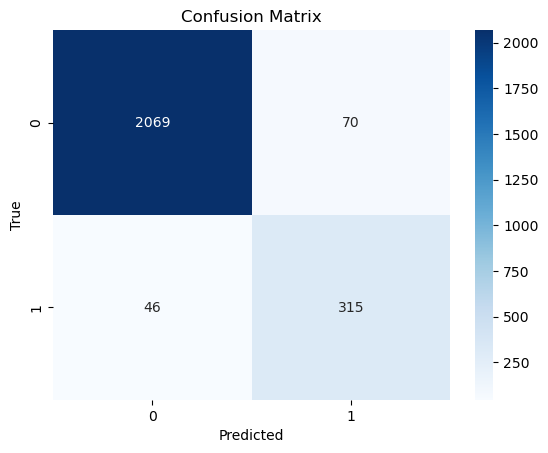

Accuracy: 0.9536, Precision: 0.8982162045991833, F1 Score: 0.9086177841136114, Recall: 0.9199253022938982


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.030000


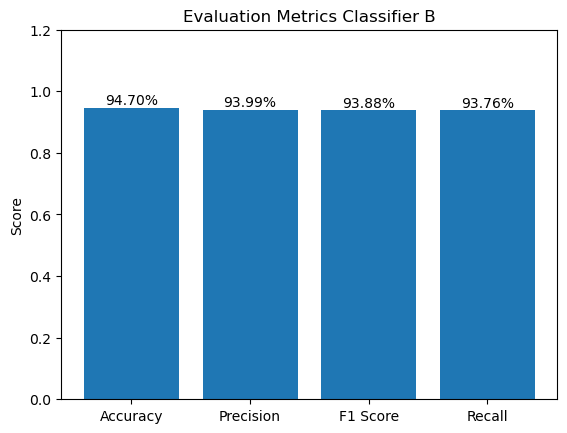

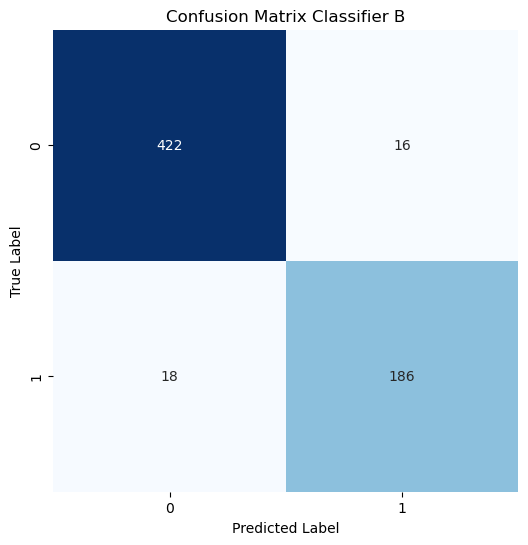

Completed iteration 6
Starting iteration 7
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.949081049851884


100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


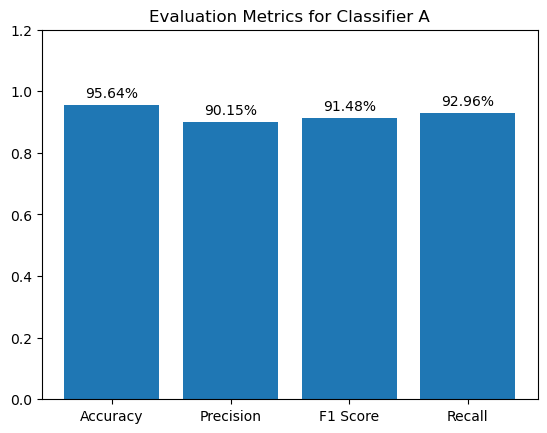

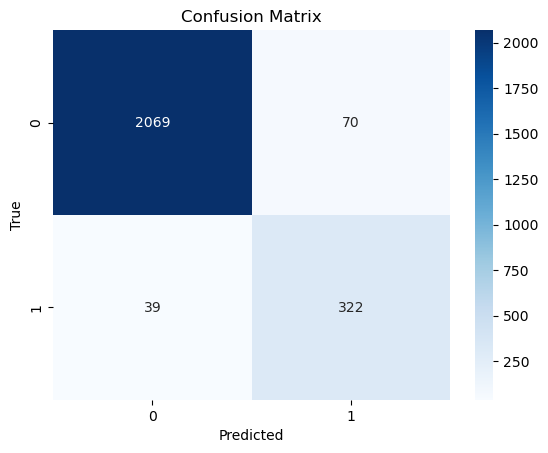

Accuracy: 0.9564, Precision: 0.901463811330984, F1 Score: 0.9147902542565003, Recall: 0.929620593152624


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


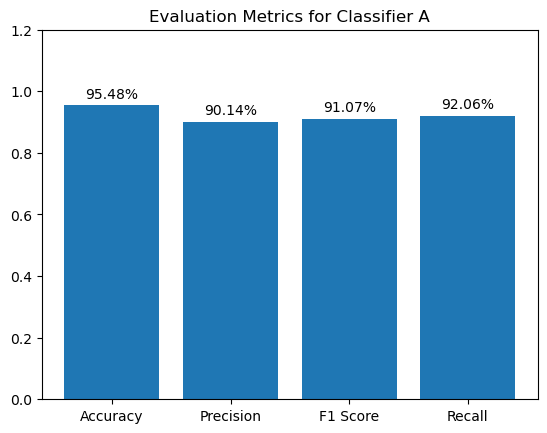

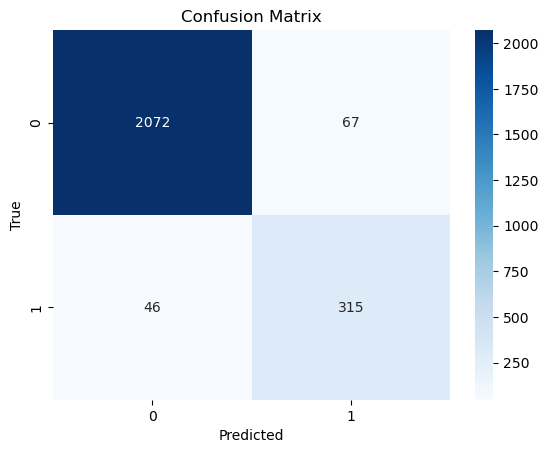

Accuracy: 0.9548, Precision: 0.9014443636938928, F1 Score: 0.9106846739010501, Recall: 0.9206265645659879


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


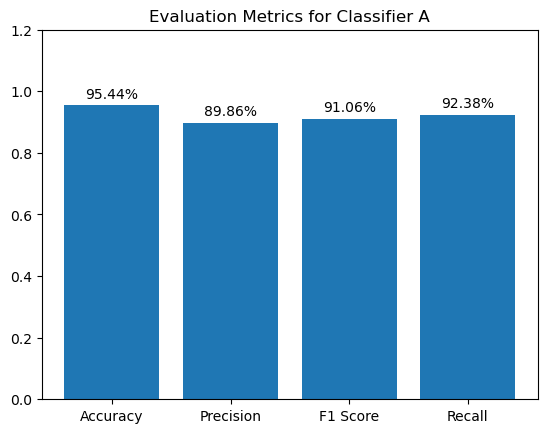

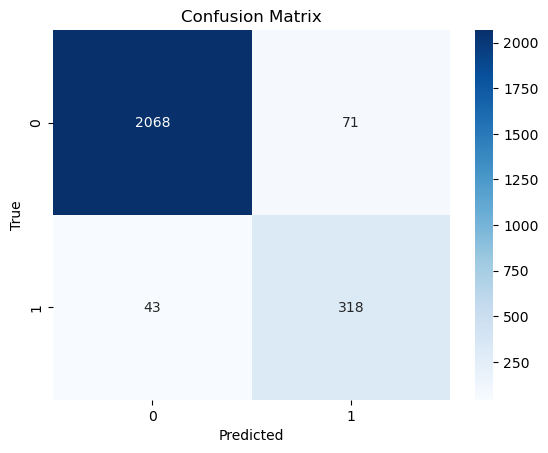

Accuracy: 0.9544, Precision: 0.8985556133315635, F1 Score: 0.9105882352941177, Recall: 0.9238466728569412


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.030700


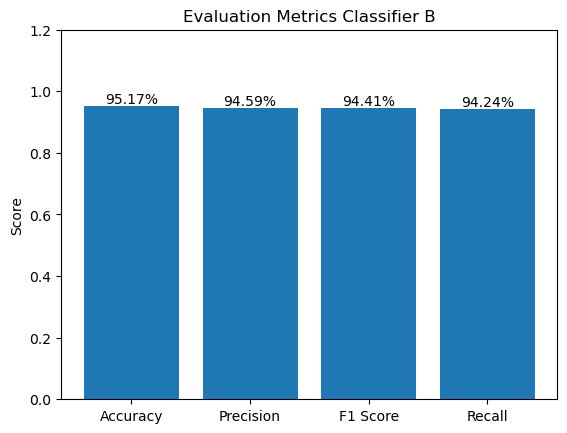

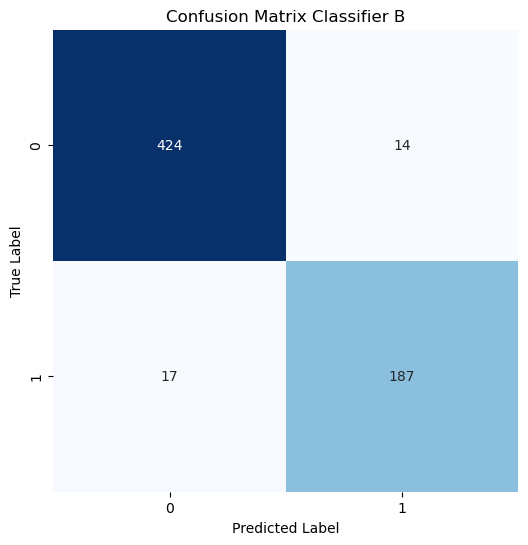

Completed iteration 7
Starting iteration 8
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.6583151522063417


100%|██████████| 9/9 [00:00<00:00, 126.25it/s]


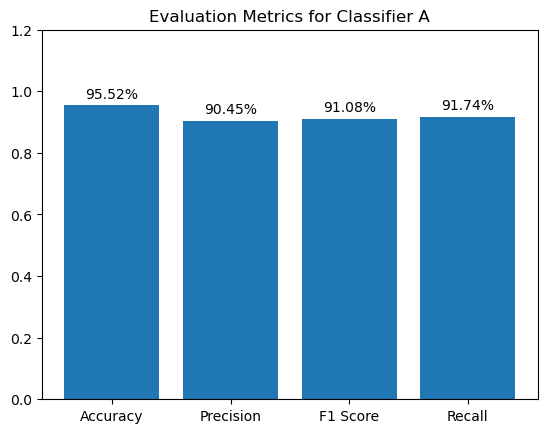

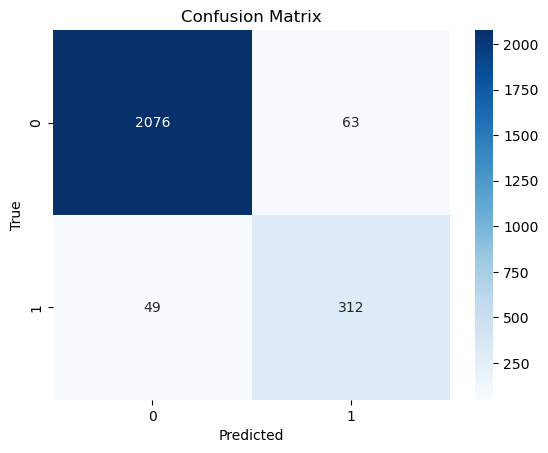

Accuracy: 0.9552, Precision: 0.9044705882352941, F1 Score: 0.9107798352231014, Recall: 0.9174064562750346


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 130.84it/s]


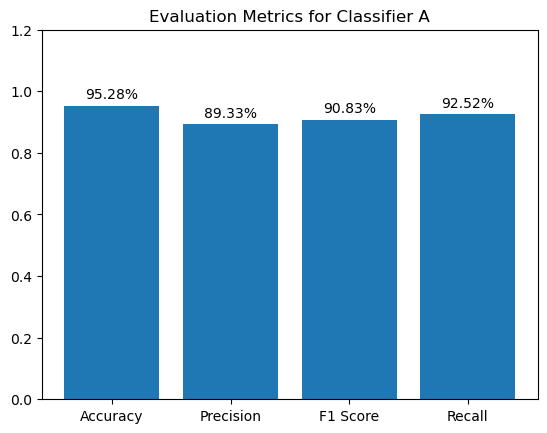

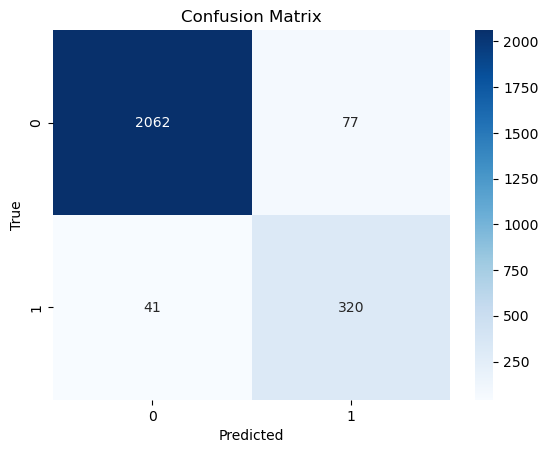

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9528, Precision: 0.8932746909476806, F1 Score: 0.9082550546799875, Recall: 0.9252142314152547


100%|██████████| 9/9 [00:00<00:00, 131.78it/s]


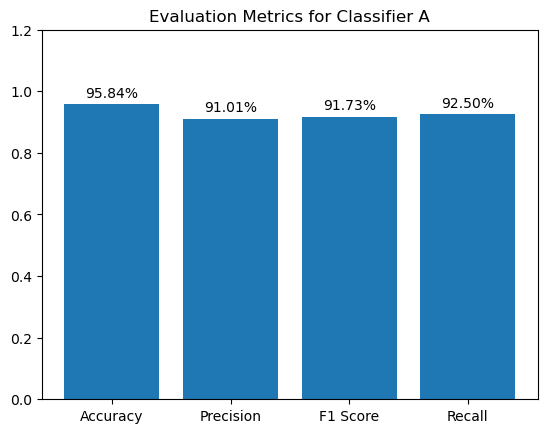

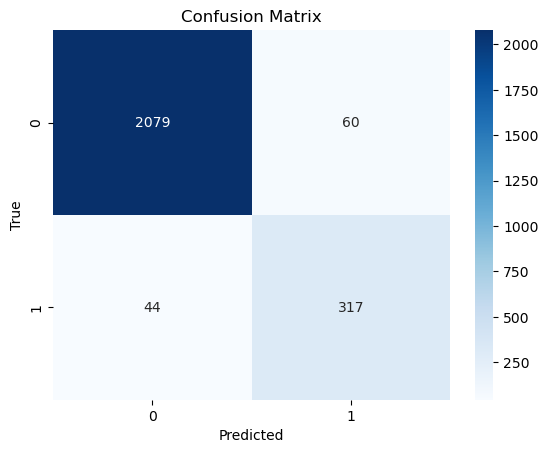

Accuracy: 0.9584, Precision: 0.9100617088825058, F1 Score: 0.9173384507190919, Recall: 0.9250329263033572


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.028200


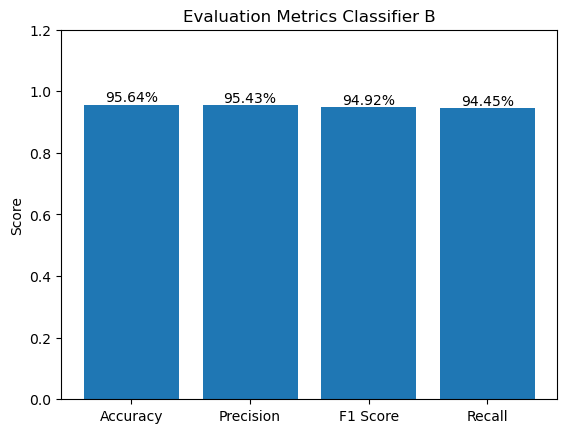

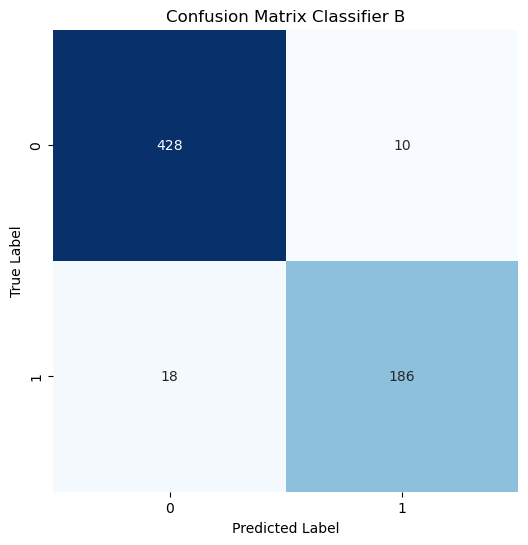

Completed iteration 8
Starting iteration 9
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.6037603580352879


100%|██████████| 9/9 [00:00<00:00, 121.17it/s]


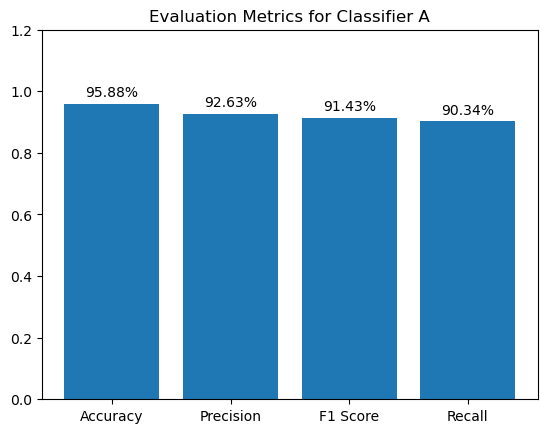

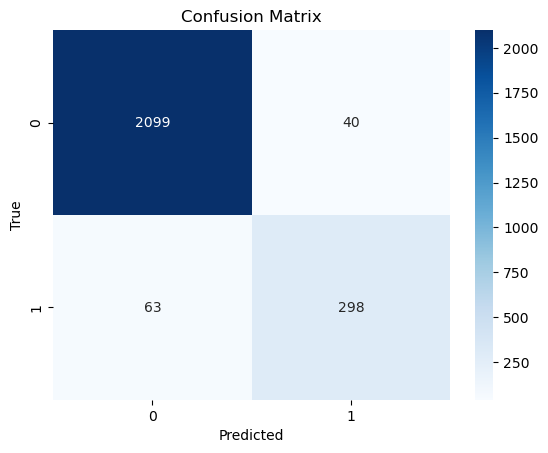

Accuracy: 0.9588, Precision: 0.9262585596286586, F1 Score: 0.9143493594828896, Recall: 0.9033922186436046


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


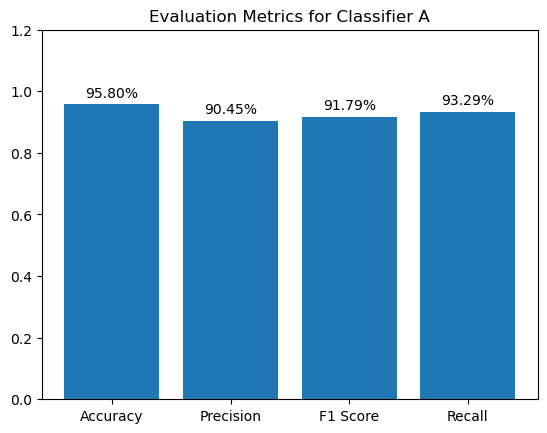

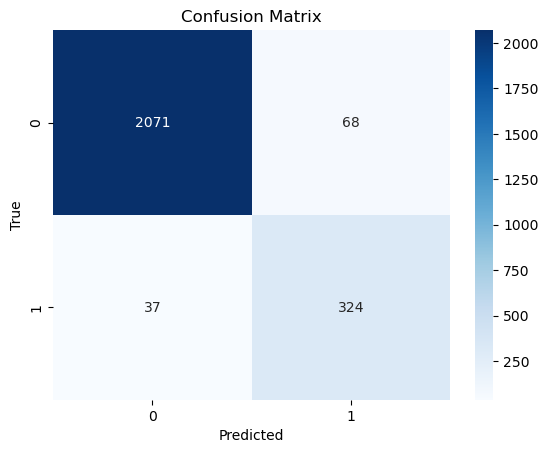

Accuracy: 0.958, Precision: 0.904489215040855, F1 Score: 0.9179172174030509, Recall: 0.9328581844365103


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 128.06it/s]


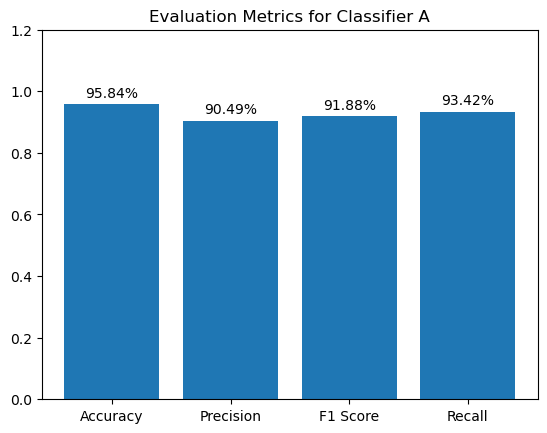

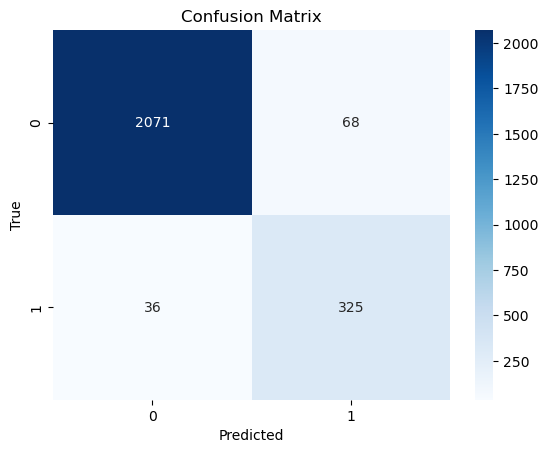

Accuracy: 0.9584, Precision: 0.9049430530245117, F1 Score: 0.9187876622216447, Recall: 0.9342432259877567


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.028000


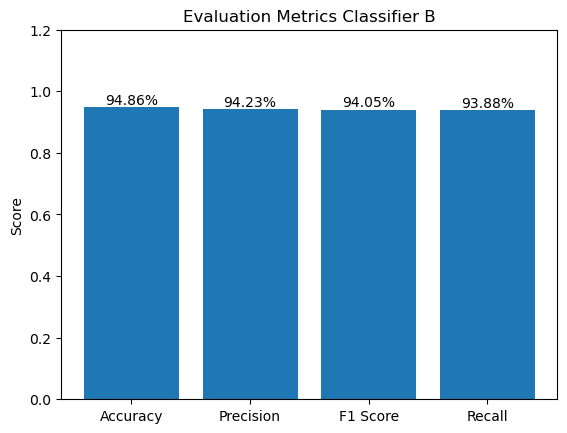

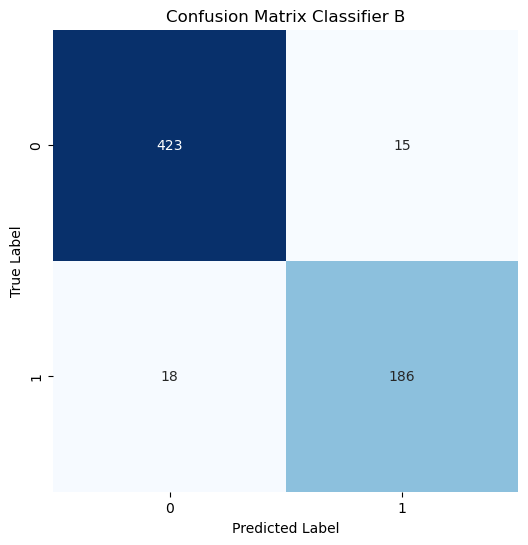

Completed iteration 9
Starting iteration 10
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels
Inconsistency in training set at index 894: 25 tokens in sentence, 27 labels
Inconsistency in training set at index 902: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 909: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 910: 23 tokens in sentence, 25 labels


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 1.1889228415311663


100%|██████████| 9/9 [00:00<00:00, 126.26it/s]


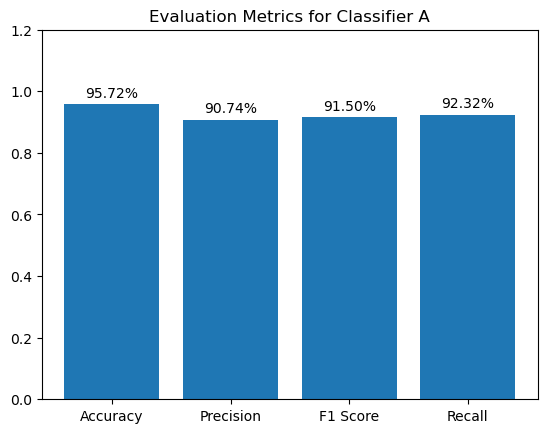

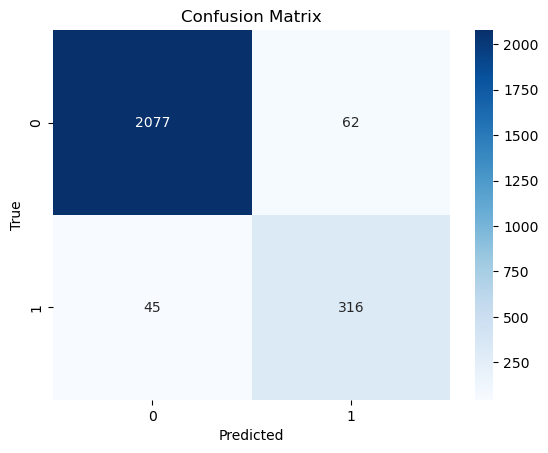

Accuracy: 0.9572, Precision: 0.9073862134653841, F1 Score: 0.9150491333582522, Recall: 0.9231803765707174


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 128.97it/s]


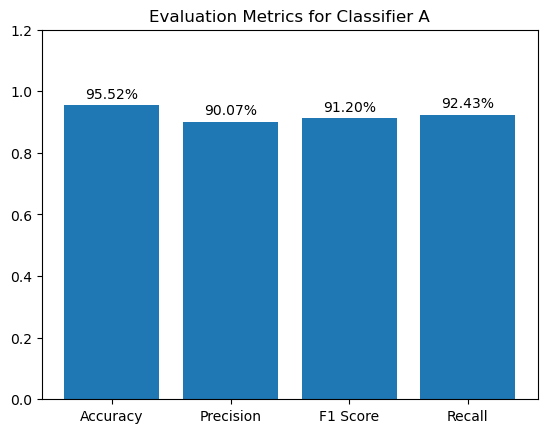

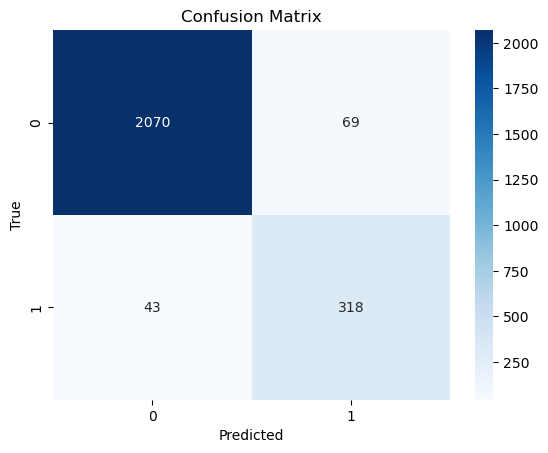

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9552, Precision: 0.900677606694622, F1 Score: 0.9119634170267782, Recall: 0.9243141810383344


100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


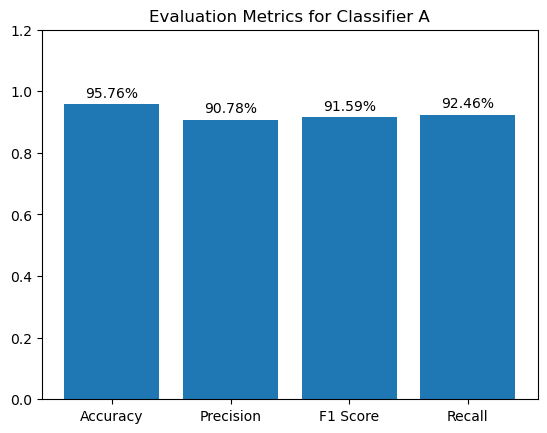

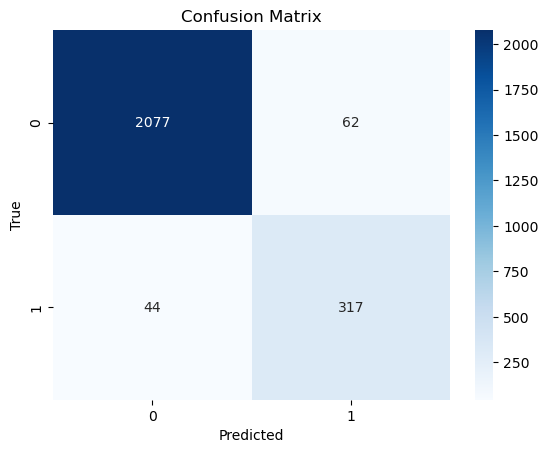

Accuracy: 0.9576, Precision: 0.90783333893133, F1 Score: 0.9159370638243878, Recall: 0.924565418121964


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.036500


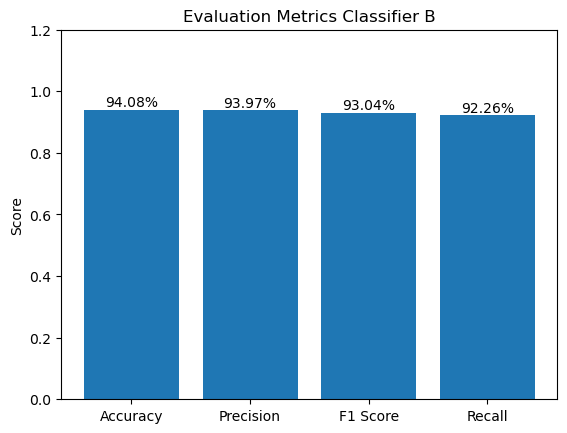

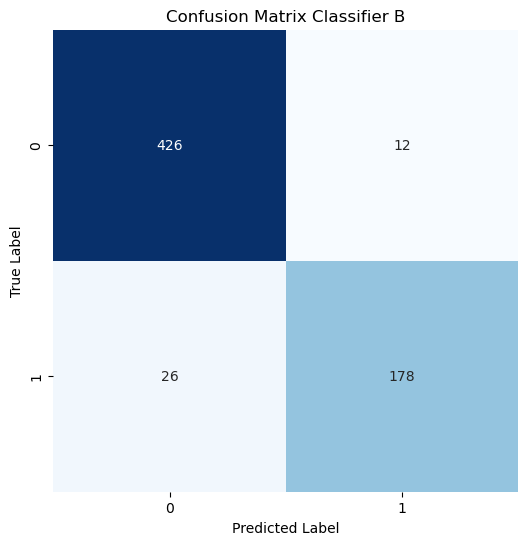

Completed iteration 10
Starting iteration 11
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels
Inconsistency in training set at index 894: 25 tokens in sentence, 27 labels
Inconsistency in training set at index 902: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 909: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 910: 23 tokens in sentence, 25 labels
Inconsistency in training set at 

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 1.0526143107854296


100%|██████████| 9/9 [00:00<00:00, 131.79it/s]


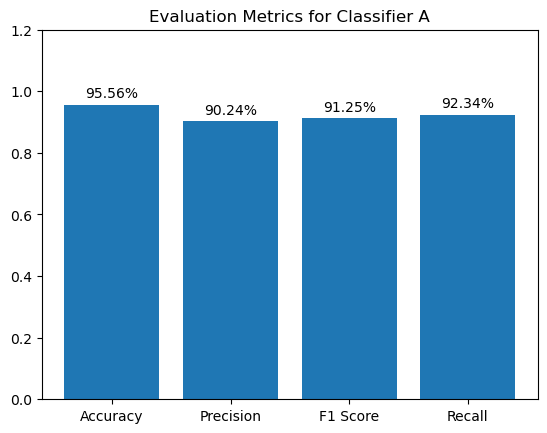

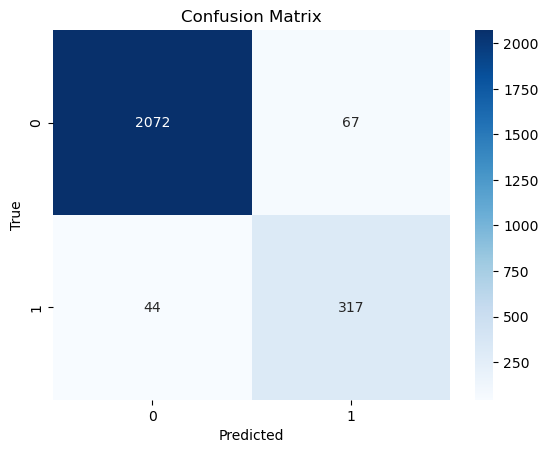

Accuracy: 0.9556, Precision: 0.9023634412413359, F1 Score: 0.9124598774438285, Recall: 0.9233966476684811


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 128.05it/s]


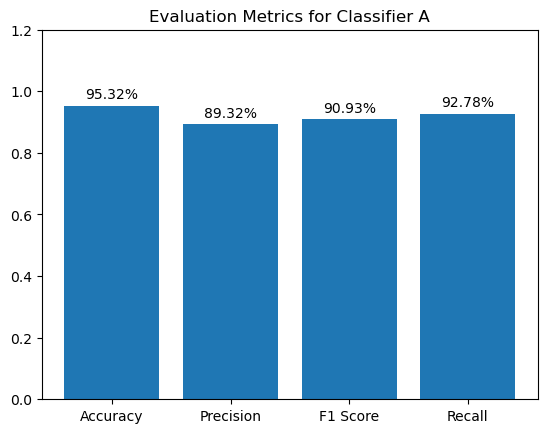

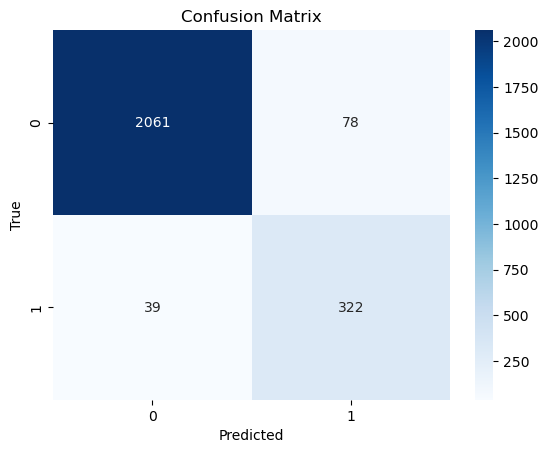

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9532, Precision: 0.8932142857142857, F1 Score: 0.9093270392348876, Recall: 0.9277505604270513


100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


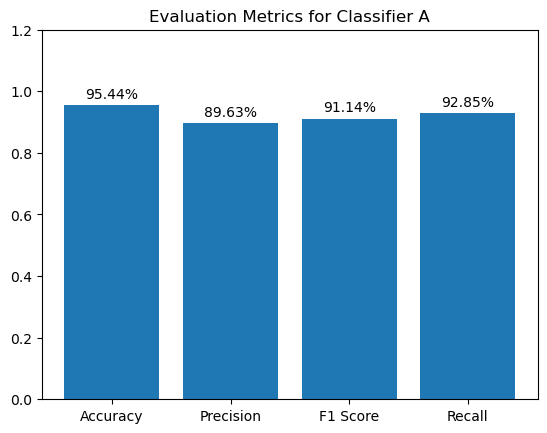

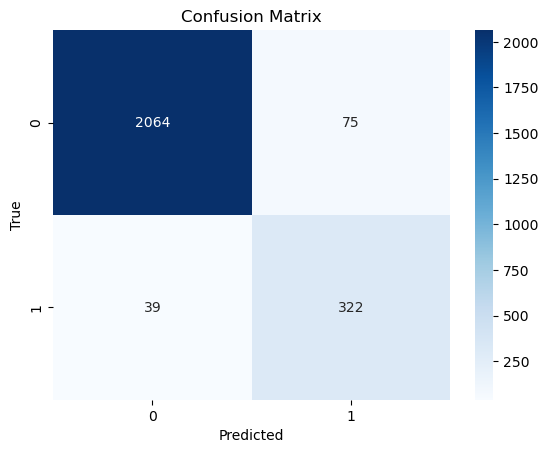

Accuracy: 0.9544, Precision: 0.8962690938098505, F1 Score: 0.9113650528264285, Recall: 0.928451822699141


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.062500


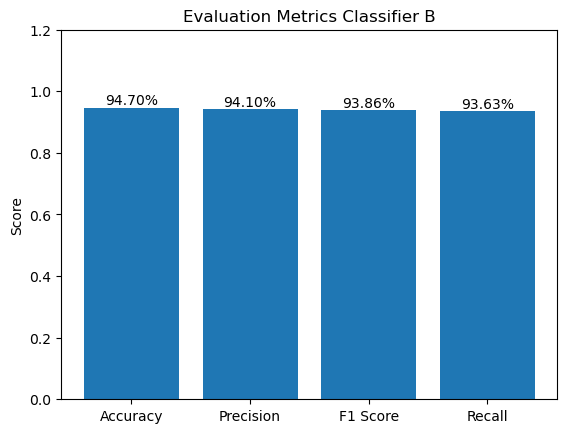

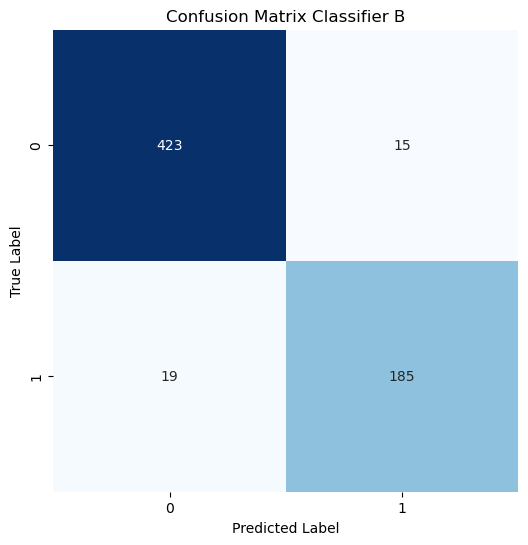

Completed iteration 11
Starting iteration 12
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels
Inconsistency in training set at index 894: 25 tokens in sentence, 27 labels
Inconsistency in training set at index 902: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 909: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 910: 23 tokens in sentence, 25 labels
Inconsistency in training set at 

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.7591729843516077


100%|██████████| 9/9 [00:00<00:00, 126.26it/s]


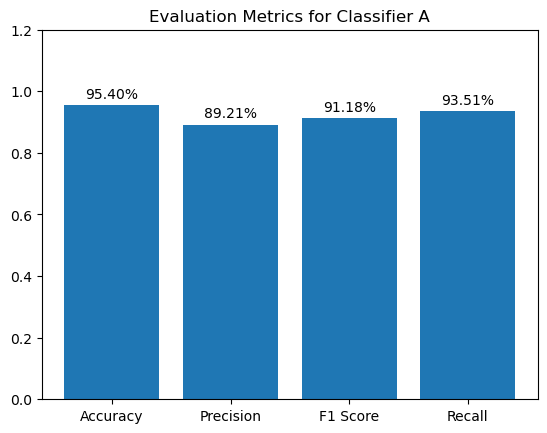

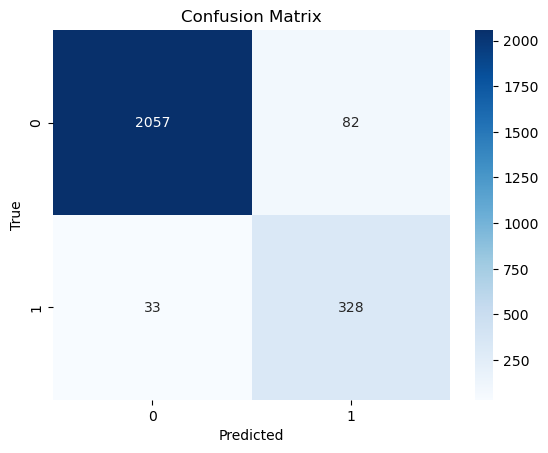

Accuracy: 0.954, Precision: 0.8921052631578947, F1 Score: 0.9118249355401942, Recall: 0.9351257933717441


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 126.26it/s]


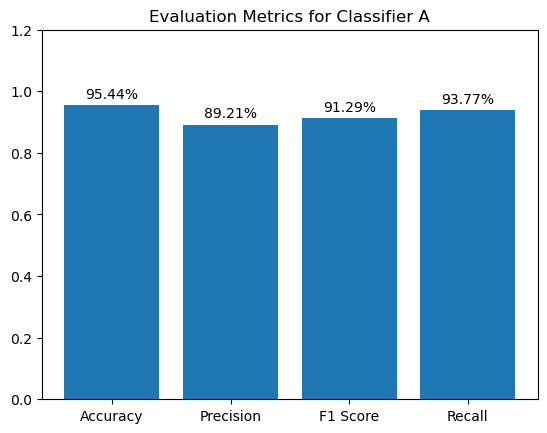

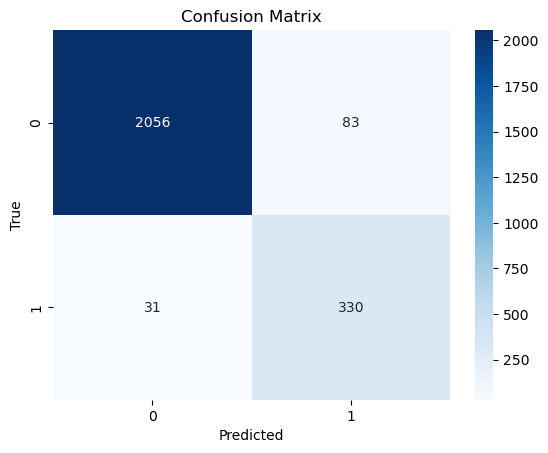

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9544, Precision: 0.8920888098931353, F1 Score: 0.9128686572968372, Recall: 0.9376621223835406


100%|██████████| 9/9 [00:00<00:00, 127.16it/s]


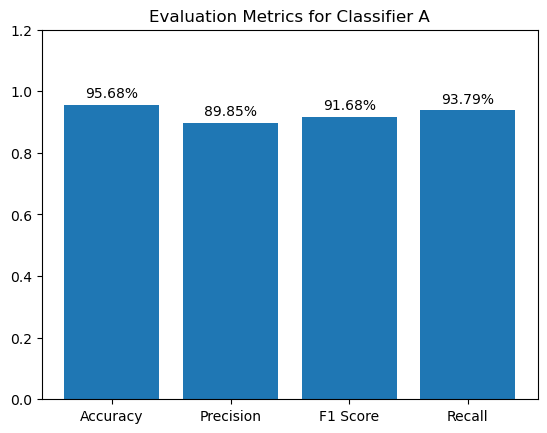

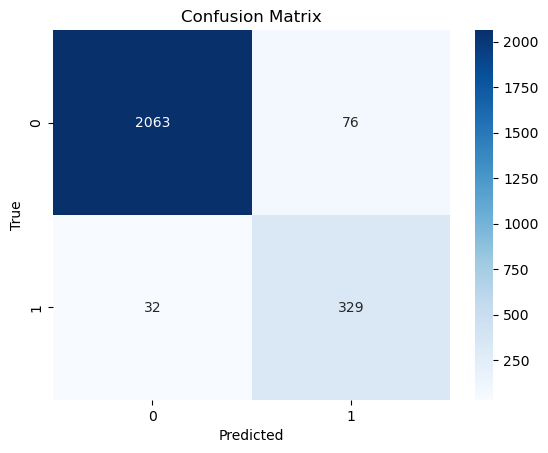

Accuracy: 0.9568, Precision: 0.8985356080025928, F1 Score: 0.9167500194249955, Recall: 0.9379133594671701


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.062900


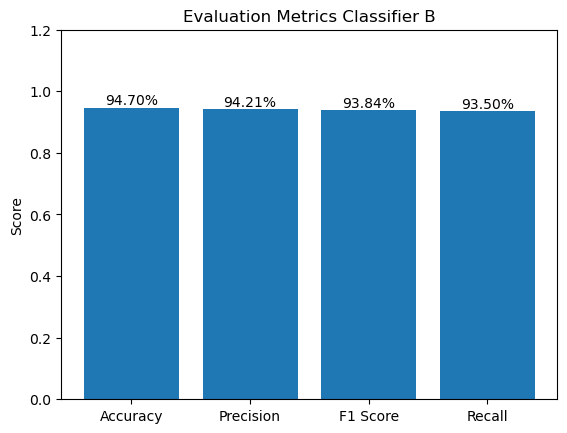

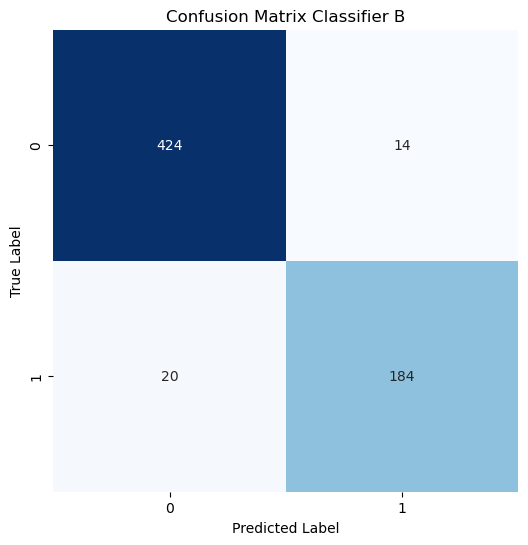

Completed iteration 12
Starting iteration 13
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels
Inconsistency in training set at index 894: 25 tokens in sentence, 27 labels
Inconsistency in training set at index 902: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 909: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 910: 23 tokens in sentence, 25 labels
Inconsistency in training set at 

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.815724916990348


100%|██████████| 9/9 [00:00<00:00, 122.00it/s]


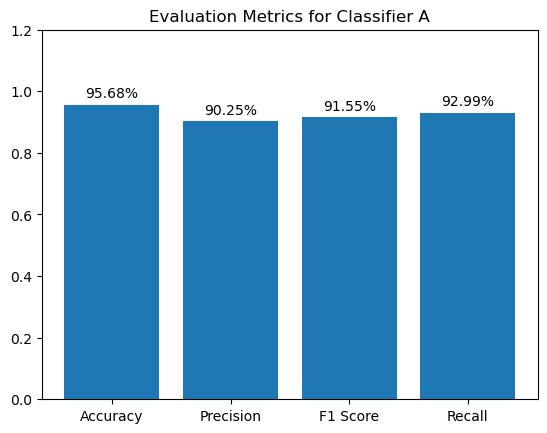

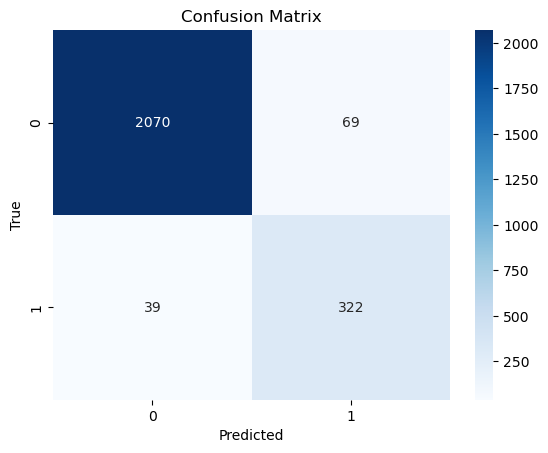

Accuracy: 0.9568, Precision: 0.9025186176888963, F1 Score: 0.9154796249549224, Recall: 0.9298543472433205


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 129.89it/s]


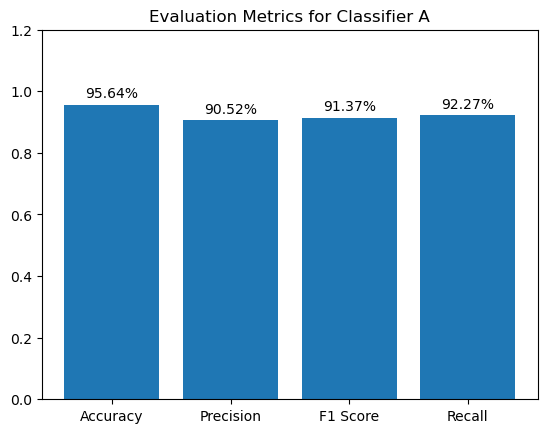

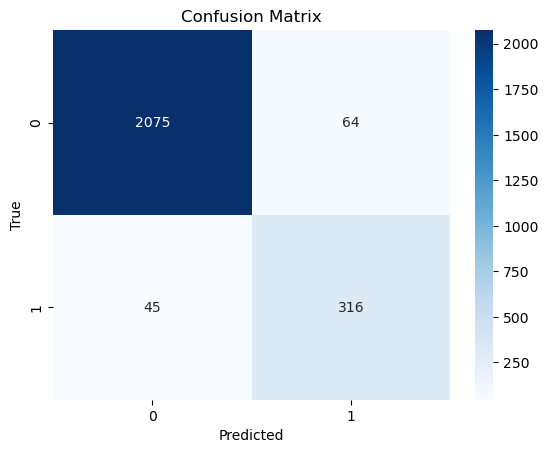

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9564, Precision: 0.9051762661370407, F1 Score: 0.9136543111531062, Recall: 0.9227128683893242


100%|██████████| 9/9 [00:00<00:00, 124.49it/s]


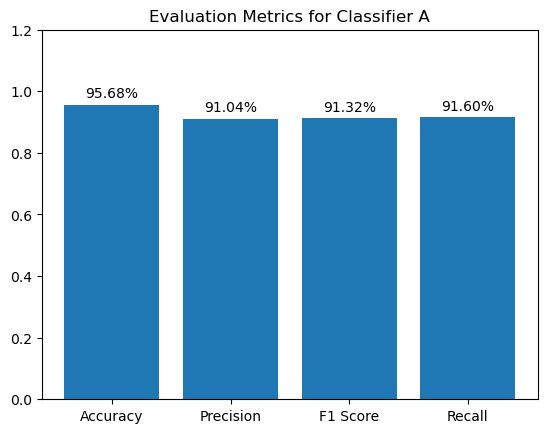

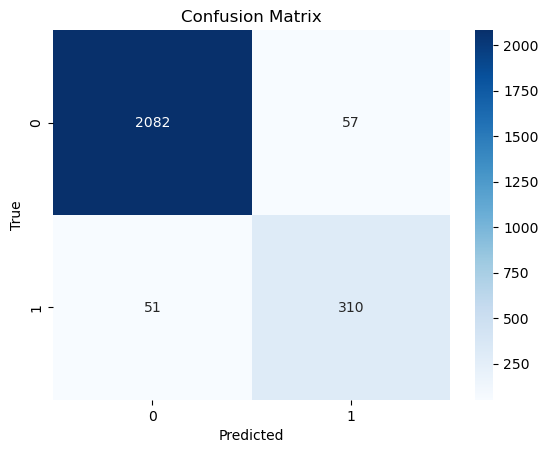

Accuracy: 0.9568, Precision: 0.9103883312830301, F1 Score: 0.9131837263859737, Recall: 0.9160388977167211


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.057500


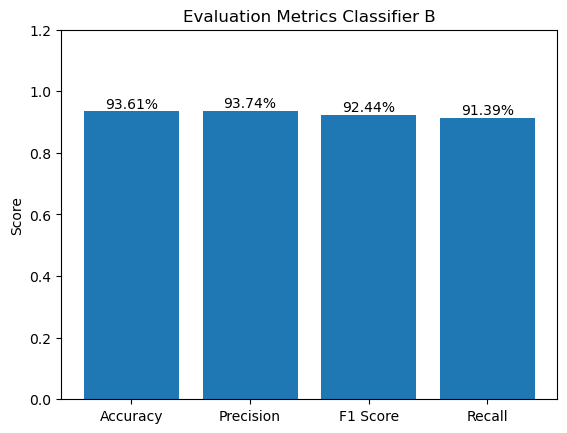

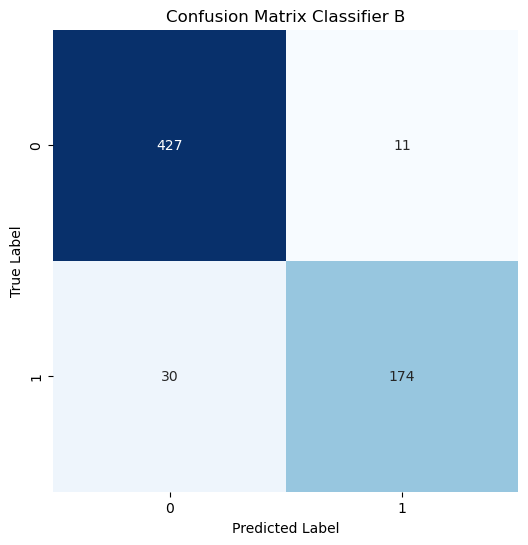

Completed iteration 13
Starting iteration 14
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels
Inconsistency in training set at index 894: 25 tokens in sentence, 27 labels
Inconsistency in training set at index 902: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 909: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 910: 23 tokens in sentence, 25 labels
Inconsistency in training set at 

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.8772486312846013


100%|██████████| 9/9 [00:00<00:00, 128.98it/s]


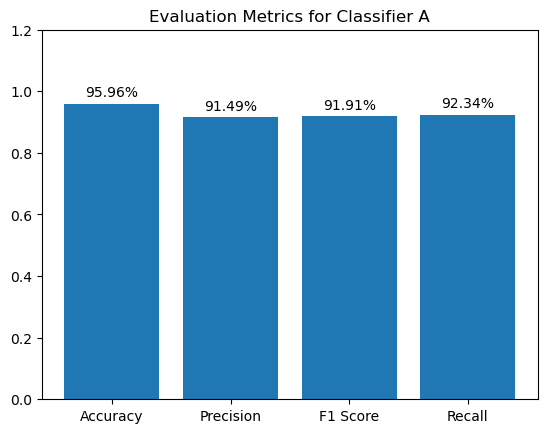

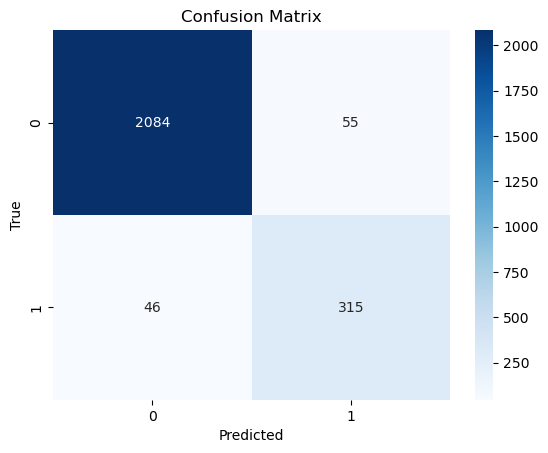

Accuracy: 0.9596, Precision: 0.9148775536099479, F1 Score: 0.9190870844080331, Recall: 0.923431613654347


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 124.51it/s]


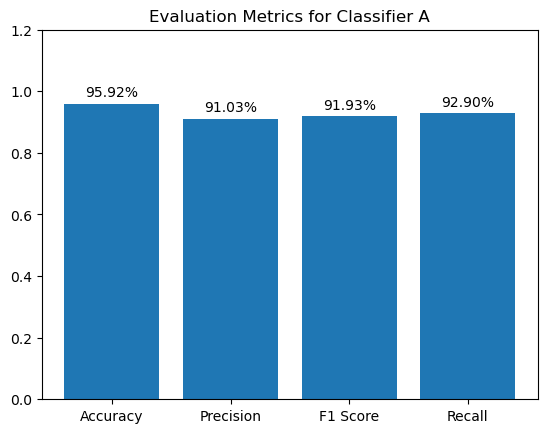

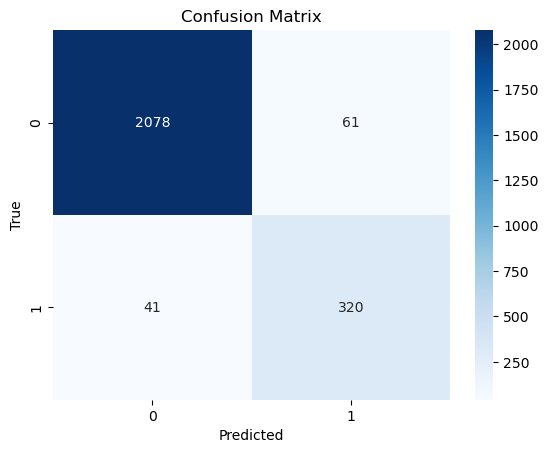

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9592, Precision: 0.9102731318566302, F1 Score: 0.9192893921573344, Recall: 0.9289542968664002


100%|██████████| 9/9 [00:00<00:00, 131.79it/s]


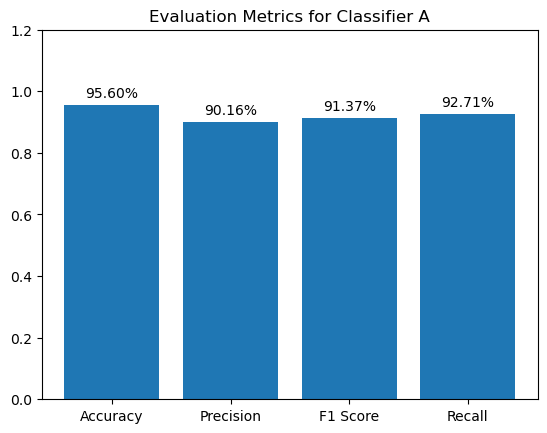

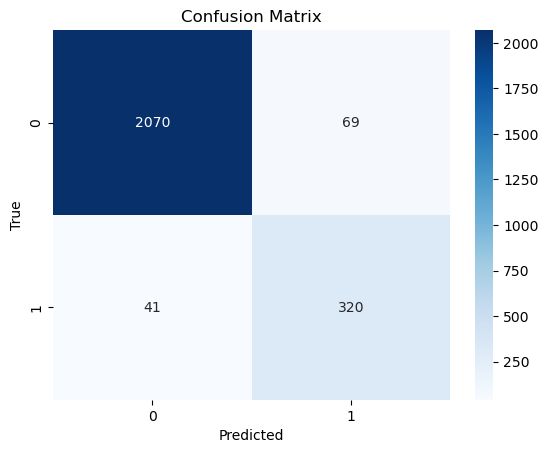

Accuracy: 0.956, Precision: 0.9016000165615536, F1 Score: 0.9137254901960784, Recall: 0.9270842641408275


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.086300


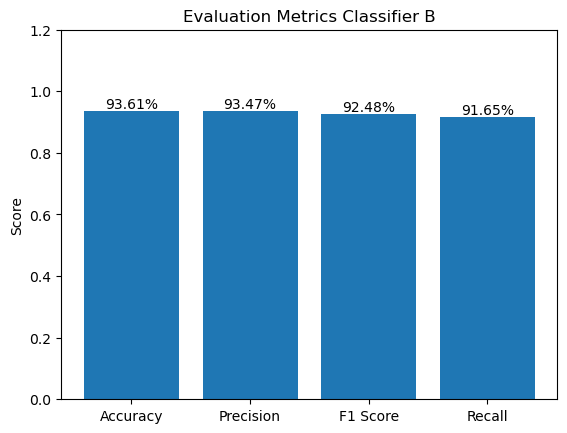

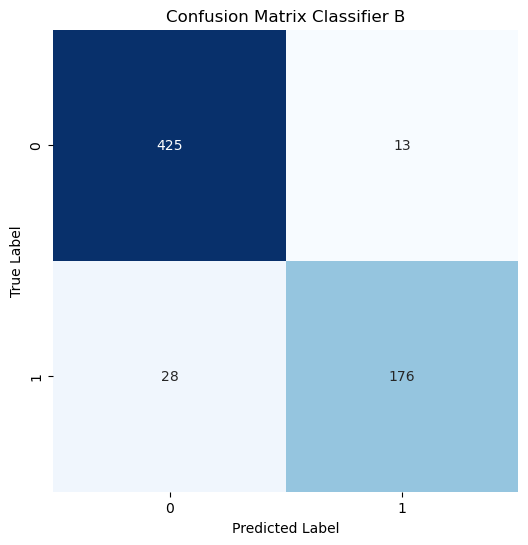

Completed iteration 14
Starting iteration 15
Inconsistency in training set at index 577: 30 tokens in sentence, 32 labels
Inconsistency in training set at index 623: 66 tokens in sentence, 68 labels
Inconsistency in training set at index 667: 44 tokens in sentence, 45 labels
Inconsistency in training set at index 691: 37 tokens in sentence, 39 labels
Inconsistency in training set at index 706: 20 tokens in sentence, 22 labels
Inconsistency in training set at index 775: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 788: 46 tokens in sentence, 48 labels
Inconsistency in training set at index 827: 7 tokens in sentence, 8 labels
Inconsistency in training set at index 894: 25 tokens in sentence, 27 labels
Inconsistency in training set at index 902: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 909: 15 tokens in sentence, 17 labels
Inconsistency in training set at index 910: 23 tokens in sentence, 25 labels
Inconsistency in training set at 

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1044893840.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(highest_rows_col)


Training Loss: 0.8218923938175067


100%|██████████| 9/9 [00:00<00:00, 122.82it/s]


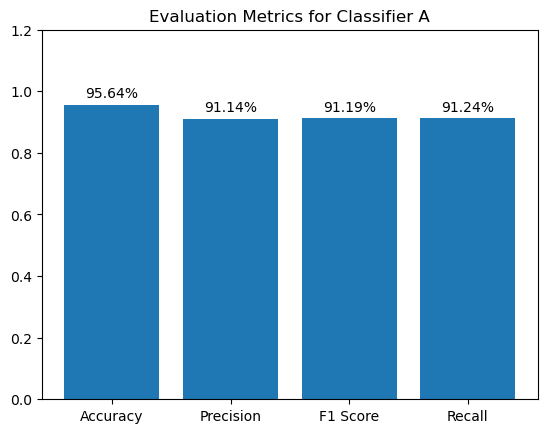

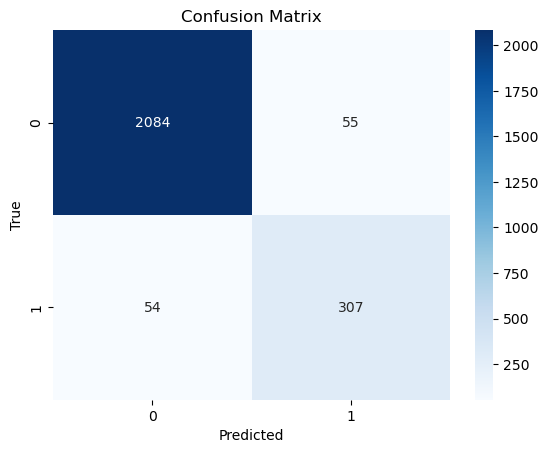

Accuracy: 0.9564, Precision: 0.9114045242882025, F1 Score: 0.9118770638149114, Recall: 0.9123512812443747


C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 9/9 [00:00<00:00, 126.26it/s]


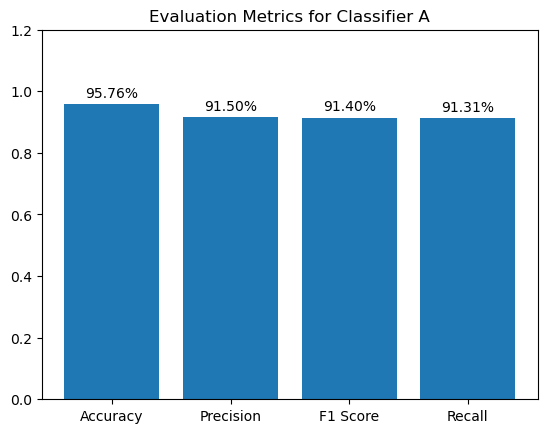

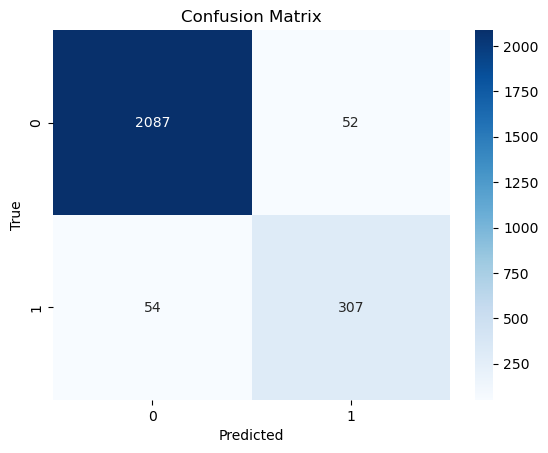

C:\Users\Anwender\AppData\Local\Temp\ipykernel_8668\1007951674.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}


Accuracy: 0.9576, Precision: 0.9149656721991, F1 Score: 0.9140057113187954, Recall: 0.9130525435164645


100%|██████████| 9/9 [00:00<00:00, 129.88it/s]


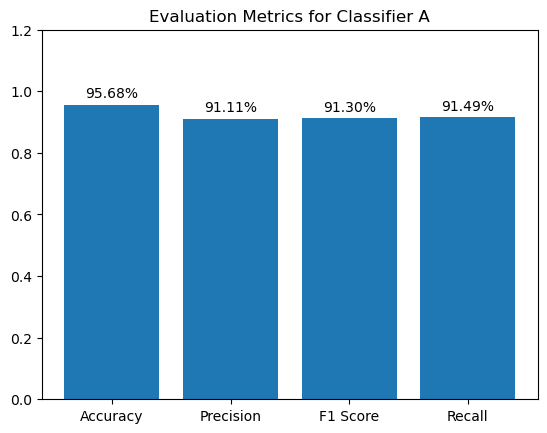

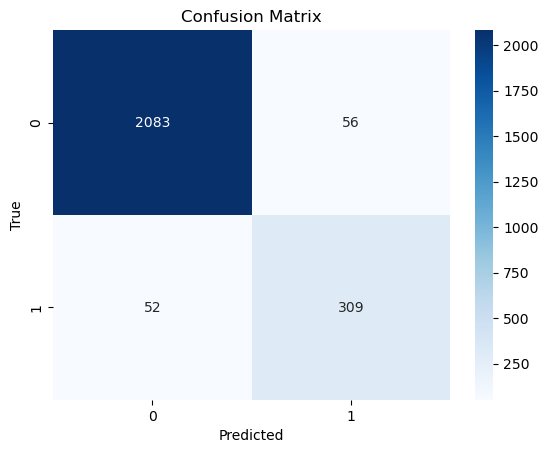

Accuracy: 0.9568, Precision: 0.911109685284399, F1 Score: 0.9129853003167335, Recall: 0.9148876102561712


C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.083300
1000,0.084900


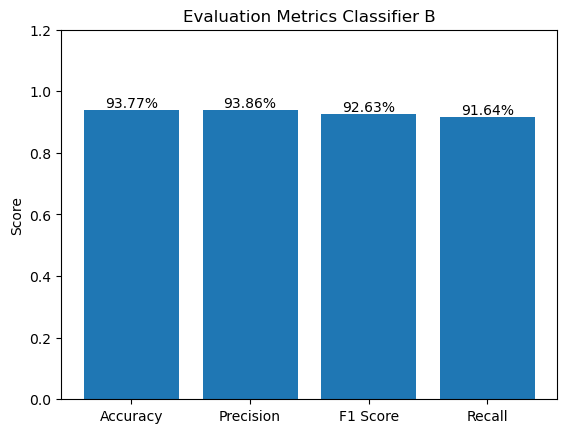

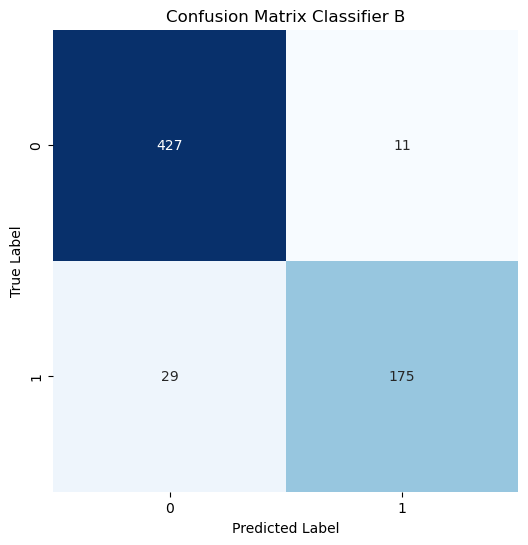

Completed iteration 15


In [15]:
# Co-training algorithm which is described in thesis

# find entry with highest probability
def find_highest_prob_rows(df, columns, top_k=10):
    max_rows = {col: df.nlargest(top_k, col) for col in columns}
    return max_rows

# remove this entry from the unlabeled data set and add it to the labeled data set with the predicted class labels
def move_highest_prob_rows(unlabeled_df, train_df, columns, top_k=10):
    highest_rows = find_highest_prob_rows(unlabeled_df, columns, top_k)
    
    # Iterate through the columns
    for col_name in columns:
        # Get the rows with the highest probability
        highest_rows_col = highest_rows[col_name]
        
        # Append the rows to the training DataFrame
        train_df = train_df.append(highest_rows_col)
        
        # Remove the rows from the unlabeled DataFrame
        unlabeled_df.drop(highest_rows_col.index, inplace=True)

        # Reset index of the unlabeled dataframe
        unlabeled_df.reset_index(drop=True, inplace=True)

    train_df.reset_index(drop=True, inplace=True)
    
    return unlabeled_df, train_df

column_names_token = ['Animated_True_Token', 'Animated_False_Token']
column_names_NP = ['Animated_True_NP', 'Animated_False_NP']

# I set the range to 15. You can modify this number
for i in range(15):
    print(f"Starting iteration {i+1}")

    # Find and move the rows with the highest probabilities for unlabeled_df_A_pred
    unlabeled_df_A_pred, train_df = move_highest_prob_rows(unlabeled_df_A_pred, train_df, column_names_token)
    
    # Find and move the rows with the highest probabilities for unlabeled_df_B_pred
    unlabeled_df_B_pred, train_df = move_highest_prob_rows(unlabeled_df_B_pred, train_df, column_names_NP)
    
    # Train classifier A with the updated train_df
    trained_model_A = train_classifier_A(train_df, valid_df)
    
    # Train classifier B with the updated train_df
    trained_model_B = train_classifier_B(train_df, valid_df)

    print(f"Completed iteration {i+1}")

In [16]:
# Function to check for empty columns and return the columns and their counts
def check_empty_columns(dataframe, column_names):
    empty_columns = {}
    for column_name in column_names:
        if column_name in dataframe.columns:
            empty_count = dataframe[column_name].isna().sum()
            if empty_count > 0:
                empty_columns[column_name] = empty_count
    return empty_columns

# Columns to check for emptiness
columns_to_check = ['Animated_Token', 'Animated_NP']

# Checking the train_df
empty_columns_in_train_df = check_empty_columns(train_df, columns_to_check)
print("In train_df, Empty Columns and Counts: ", empty_columns_in_train_df)

# Checking the valid_df
empty_columns_in_valid_df = check_empty_columns(valid_df, columns_to_check)
print("In valid_df, Empty Columns and Counts: ", empty_columns_in_valid_df)

In train_df, Empty Columns and Counts:  {}
In valid_df, Empty Columns and Counts:  {}
